# Capstone Project

### Import required libraries

In [37]:
import numpy as np
#in case we need to repeat experiment
np.random.seed(255)

import pandas as pd
pd.options.display.max_rows = 25

import matplotlib.pyplot as plt
plt.style.use('classic')

import seaborn as sns
sns.set()

from IPython.display import display, HTML

%matplotlib inline
%precision 3
debug = False

## Utility Functions for this project

In [2]:
def plotSimpleHist(data, title, hight=10, width=10):
    plot_enabled = True
    if(plot_enabled):
        shist = data.value_counts().plot(figsize=(width,hight), kind='bar',title=title, stacked = False)
        shist.set(xlabel=data.name, ylabel='Accident Count')

In [3]:
# list the accident severity count
def severity_count(data):
    sv_count = data.value_counts()
    sv_count.index.name = 'Severity'
    df_sv_count = pd.DataFrame({'Count':sv_count.values}, index = sv_count.index)
    df_sv_count.rename(index={'1':'non-fatal','2':'injury', '3':'fatal'},inplace=True)
    return df_sv_count

In [4]:
# list the accident severity count by dependent variable
def by_severity_count(data, ind, dep):
    bg_count = data.groupby([data[dep],data[ind]])
    sv_count = bg_count.size().unstack() 
    sv_count.index.name = 'Severity'
    sv_count.columns.name = ''
    sv_count.rename(index={'1':'non-fatal','2':'injury', '3':'fatal'},inplace=True)
    sv_count.fillna(value=0, inplace=True)
    sv_count.transpose()
    return sv_count

In [51]:
#plot histogram
def checkHistogram(df, feature, pred, plot):
    by_level = df.groupby([feature,pred]).size().unstack()

    if(plot):
        plot = by_level.plot(figsize=(20,15), kind='bar',title='Weather Configuration', stacked = False);
            
    return by_level

In [52]:
#functions
debug2 = False

def selectBin(start, end, P, leadingZero = False):
    x = np.random.choice(np.arange(start, end), p = P)
    if debug2:
        print("Selected bin: {0}".format(x))
    if leadingZero:
        if x < 10:
            x = '0' + str(x)
    return str(x)

In [53]:
#compute the probability of each bin
def computeP(dataFrm):
    N = dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')].sum().sum()
    if debug:
        print(dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')])
        print(N)
    
    maxCol = dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')].max()

    #calculate the probability of the each category
    P=[]
    cur = 1;
    for ind in dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')]:
        if debug:
            print("ind: {0}".format(ind))
            print("cur: {0}".format(cur))
            
        # some categoris may not have any values
        # we need to build the P matrix for the same number of colums
        end = int(ind)
        if cur < end:
            for i in range(cur, end):
                print("i: {0}".format(i))
                P.append(0)
                cur = cur +1
                
        p = dataFrm.loc[ind].sum()/N
        P.append(p)
        cur = cur +1
    
    if debug:
        print(P)
        print(np.sum(P))
    
    return P      


In [57]:
# remove unwanted data from the dataset
def cleanData(df, dep, ind, replace, binStart, binLast, appendZero=False):
    #display(by_severity_count(df, dep, ind))
    print("{count} non-numeric rows observed".format(count = df[dep].astype('str').str.contains('[^0-9]').sum()))
    gby = checkHistogram(df, dep, ind, False)
    P = computeP(gby)
    for item in replace:
        data_to_impute = df[dep].astype('str').str.contains(item)
        df[data_to_impute] = df.loc[data_to_impute].apply(lambda x: x.replace(item, selectBin(binStart, binLast, P, appendZero)))
    print("{count} non-numeric rows observed".format(count = df[dep].astype('str').str.contains('[^0-9]').sum()))
    #display(by_severity_count(df, dep, ind))

### Read data file

In [5]:
#df = pd.read_csv('NCDB_2016.csv', engine = 'python')
df = pd.read_csv('NCDB_1999_to_2016.csv', engine = 'python')

### Number of rows and columns

In [6]:
print(df.shape)

(6486831, 23)


### List dataset columns

In [7]:
print(df.columns)

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_SEV', 'C_VEHS', 'C_CONF',
       'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE',
       'V_YEAR', 'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER', 'C_CASE'],
      dtype='object')


In [8]:
print(df.head(2))

   C_YEAR C_MNTH C_WDAY C_HOUR  C_SEV C_VEHS C_CONF C_RCFG C_WTHR C_RSUR  \
0    1999     01      1     20      2     02     34     UU      1      5   
1    1999     01      1     20      2     02     34     UU      1      5   

   ...   V_TYPE V_YEAR P_ID P_SEX P_AGE P_PSN P_ISEV P_SAFE P_USER C_CASE  
0  ...       06   1990   01     M    41    11      1     UU      1    752  
1  ...       01   1987   01     M    19    11      1     UU      1    752  

[2 rows x 23 columns]


In [9]:
## Inital type of each independent variable

In [10]:
print(df.dtypes)

C_YEAR     int64
C_MNTH    object
C_WDAY    object
C_HOUR    object
C_SEV      int64
C_VEHS    object
C_CONF    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_ID      object
V_TYPE    object
V_YEAR    object
P_ID      object
P_SEX     object
P_AGE     object
P_PSN     object
P_ISEV    object
P_SAFE    object
P_USER    object
C_CASE     int64
dtype: object


### Backup a copy of the dataset

In [11]:
# backup the origial data set
dfcopy = df.copy()

### Select Pasenger Severity as the Dependent Variable
#### Move the dependent variable as the last column

In [12]:
#Move the dependent variable to the outside and drop C_CASE column
P_ISEV = df['P_ISEV']
df.drop(columns = ['P_ISEV'], inplace = True)
df['P_ISEV'] = P_ISEV

### Remove rows with more than 4 missing values
#### Preserve rows with fatal pasenger

In [13]:
### drop rows that have more than 4 missing values and P_ISEV is not fatal
missing_value_strings = ['U', 'UU', 'UUU', 'UUUU', 'N', 'NN', 'NNN', 'NNNN', 'Q', 'QQ', 'QQQ', 'QQQQ', 'X', 'XX', 'XXX', 'XXXX']
non_fatal_with_more_than_4_missing = ((df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')).sum()
df.drop(df.index[(df.isin(missing_value_strings).sum(axis=1) > 3) & ~(df['P_ISEV'] == '3')], inplace = True)
df = df.reset_index(drop=True)
print("Dropped {drop_count} rows from dataset".format(drop_count = non_fatal_with_more_than_4_missing))

Dropped 432980 rows from dataset


### Drop columns C_SEV and C_CASE
#### We will not be using them

In [14]:
#Move the dependent variable to the outside and drop C_CASE column
df.drop(columns = ['C_SEV', 'C_CASE'], inplace = True)

### Check for missing values

In [15]:
print("This dataset has {0} Null values".format(df.isnull().sum().sum()))
print("This dataset has {0} Not a Number (NaN) values".format(df.isna().sum().sum()))

This dataset has 0 Null values
This dataset has 0 Not a Number (NaN) values


## Histogram of each variable

Severity,injury,non-fatal,N,fatal,U
Count,3273354,2513281,204382,44167,18667


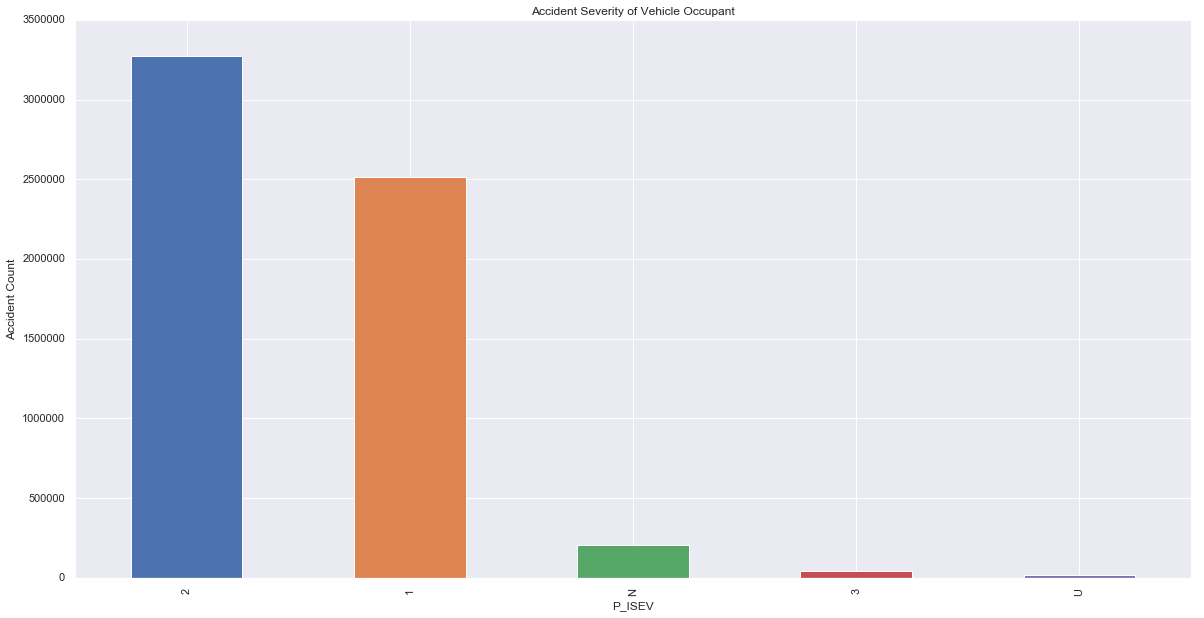

In [16]:
# Histogram of Accident Severity of Vehicle Occupant
plotSimpleHist(df['P_ISEV'], 'Accident Severity of Vehicle Occupant', hight=10, width=20)
severity_count(df['P_ISEV']).transpose()
#severity_count(df['P_ISEV'])

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Severity,,,,,,,,,,,,,,,,,,
non-fatal,164530.0,164422.0,159174.0,163251.0,156230.0,149797.0,148269.0,144475.0,140466.0,129562.0,127212.0,130351.0,127214.0,125985.0,125395.0,116694.0,122013.0,118241.0
injury,210201.0,214626.0,208485.0,214309.0,207481.0,198071.0,196115.0,191593.0,184957.0,169683.0,164400.0,165717.0,162012.0,161166.0,159124.0,151030.0,155895.0,158489.0
fatal,2980.0,2904.0,2758.0,2921.0,2777.0,2735.0,2898.0,2871.0,2753.0,2431.0,2216.0,2238.0,2023.0,2075.0,1951.0,1846.0,1895.0,1895.0
N,0.0,16784.0,16373.0,16263.0,16431.0,15991.0,15387.0,13729.0,13217.0,11739.0,11603.0,9447.0,9009.0,8279.0,7685.0,7476.0,7522.0,7447.0
U,14616.0,360.0,413.0,404.0,414.0,257.0,263.0,269.0,273.0,327.0,261.0,131.0,180.0,151.0,58.0,76.0,118.0,96.0


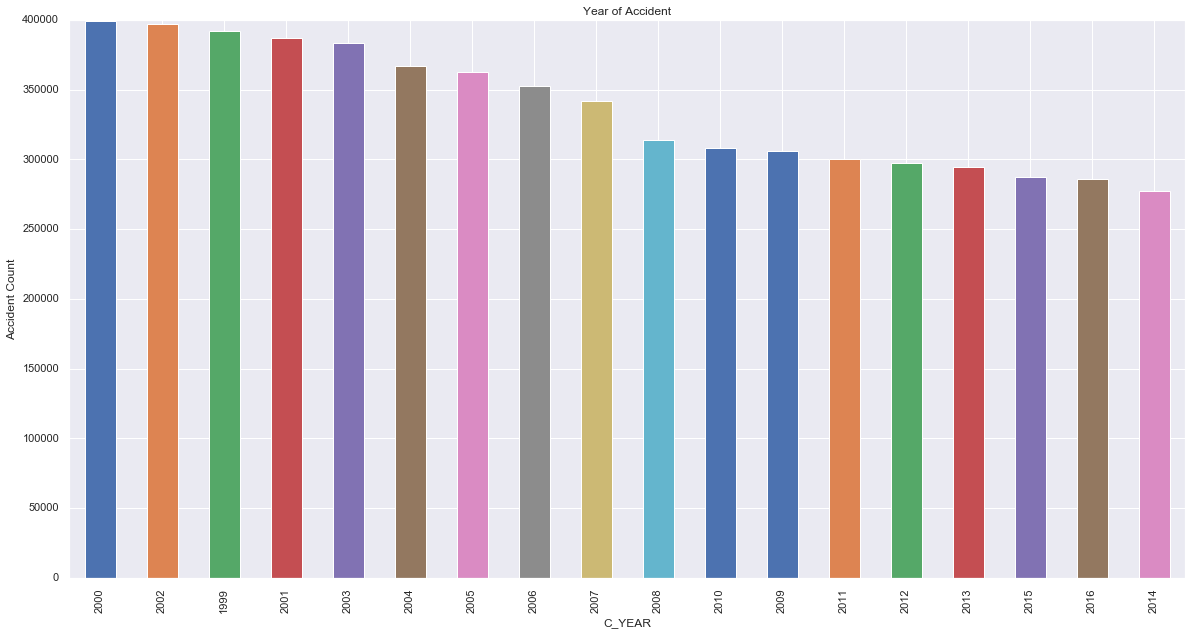

In [17]:
#Year of Accident
plotSimpleHist(df['C_YEAR'], 'Year of Accident', hight=10, width=20)
by_severity_count(df, 'C_YEAR', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,11,12,UU
Severity,,,,,,,,,,,,,
non-fatal,212435.0,183172.0,178228.0,169478.0,202060.0,222236.0,230921.0,234464.0,221662.0,222973.0,211278.0,224349.0,25.0
injury,278984.0,237052.0,231489.0,219548.0,261624.0,291477.0,302132.0,305355.0,284231.0,286927.0,281763.0,292745.0,27.0
fatal,3140.0,2649.0,2744.0,2924.0,3593.0,3973.0,4573.0,4663.0,4194.0,4133.0,3803.0,3775.0,3.0
N,18063.0,15592.0,13909.0,12507.0,16322.0,19071.0,18821.0,19862.0,18736.0,17519.0,16666.0,17314.0,0.0
U,1564.0,1101.0,1277.0,1162.0,1725.0,1752.0,1832.0,1869.0,1658.0,1582.0,1576.0,1569.0,0.0


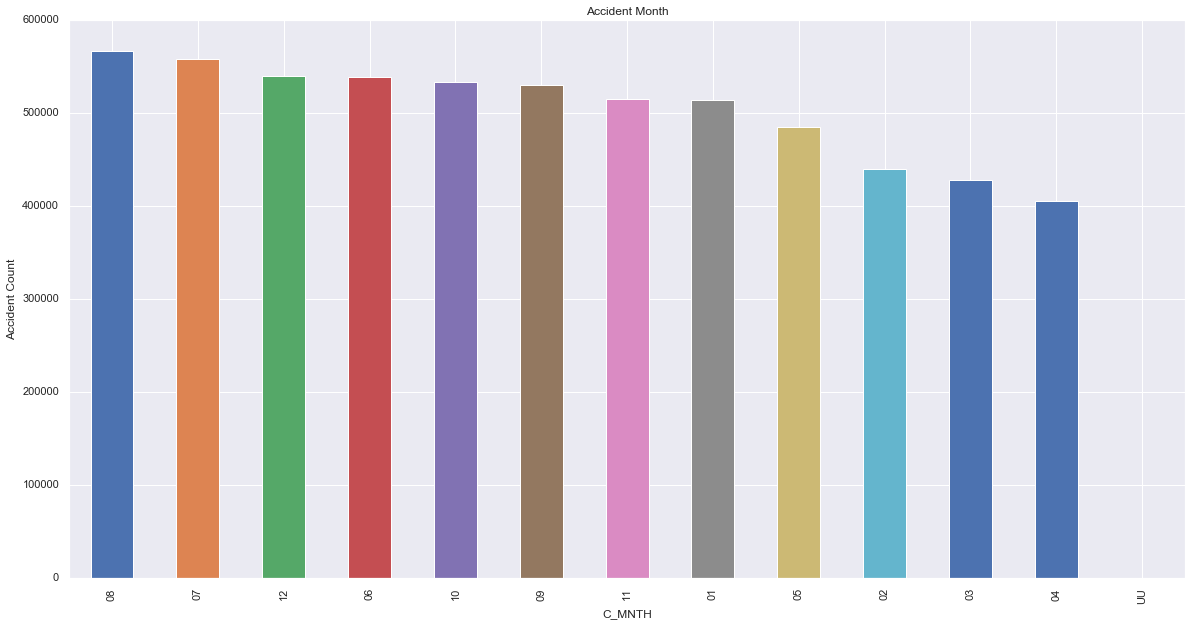

In [18]:
# Accident Month
plotSimpleHist(df['C_MNTH'], 'Accident Month', hight=10, width=20)
by_severity_count(df, 'C_MNTH', 'P_ISEV')

,1,2,3,4,5,6,7,U
Severity,,,,,,,,
non-fatal,330245.0,351875.0,354918.0,372770.0,433602.0,373642.0,295976.0,253.0
injury,438258.0,456197.0,459456.0,484191.0,550542.0,481990.0,402287.0,433.0
fatal,5466.0,5260.0,5459.0,6100.0,7186.0,7807.0,6881.0,8.0
N,26833.0,29445.0,30039.0,33314.0,36687.0,26323.0,21741.0,0.0
U,2499.0,2605.0,2608.0,2848.0,3469.0,2543.0,2094.0,1.0


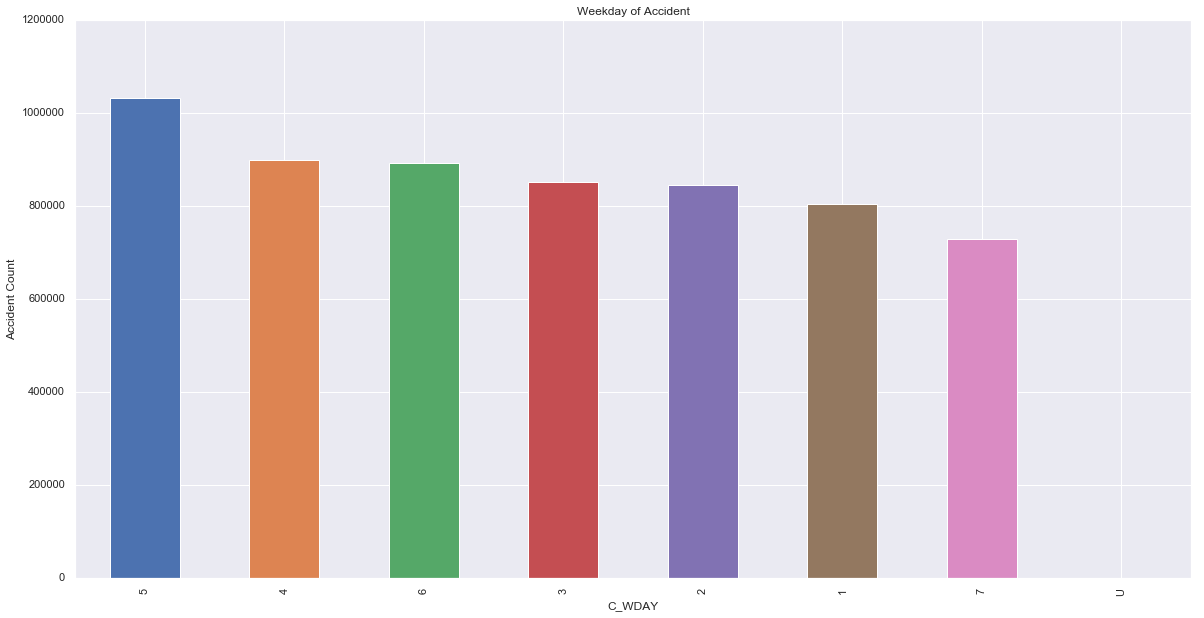

In [19]:
# Weekday of Accident
plotSimpleHist(df['C_WDAY'], 'Weekday of Accident', hight=10, width=20)
by_severity_count(df, 'C_WDAY', 'P_ISEV')

,00,01,02,03,04,05,06,07,08,09,...,15,16,17,18,19,20,21,22,23,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,30067,22821,23797,17562,10176,12828,38697,83649,132541,96822,...,227366,236727,229646,171702,123209,91198,82844,64106,46651,19249
injury,54882,46853,48548,41652,27688,32170,68782,124642,170066,131448,...,261057,278042,266734,203074,154984,122738,117036,96588,76868,30334
fatal,1418,1481,1549,1338,912,972,1343,1541,1490,1585,...,2567,2649,2594,2485,2177,2095,1972,1899,1678,627
N,2384,1588,1483,1917,884,1110,3260,8105,10931,8391,...,18039,20562,18778,12331,9198,6718,6343,4724,3543,1526
U,287,177,152,172,69,112,193,611,849,646,...,1713,1868,1615,1198,938,740,619,496,386,121


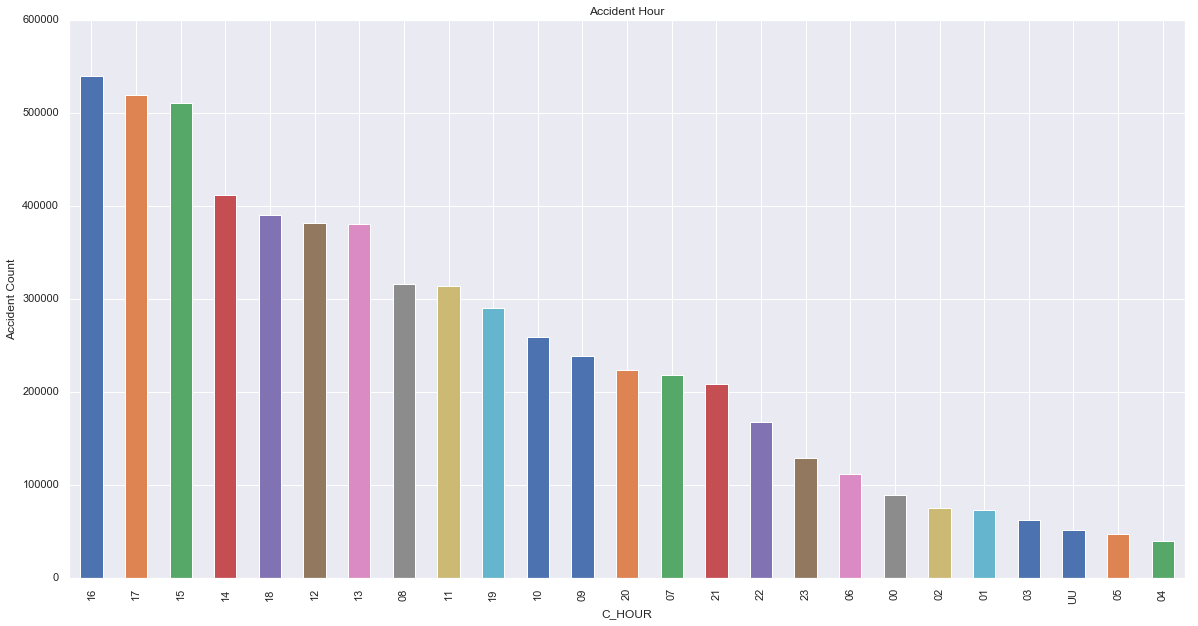

In [20]:
# Accident Hour
plotSimpleHist(df['C_HOUR'], 'Accident Hour', hight=10, width=20)
by_severity_count(df, 'C_HOUR', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,47,51,54,56,57,58,71,72,77,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,313747.0,1641440.0,405651.0,106983.0,26335.0,8486.0,3209.0,1583.0,1069.0,734.0,...,0.0,40.0,64.0,40.0,50.0,10.0,31.0,108.0,111.0,55.0
injury,882242.0,1961274.0,330311.0,72834.0,16228.0,5062.0,1773.0,827.0,466.0,329.0,...,17.0,35.0,19.0,17.0,8.0,7.0,54.0,14.0,89.0,4.0
fatal,20956.0,19201.0,2895.0,706.0,200.0,83.0,42.0,14.0,5.0,4.0,...,0.0,0.0,1.0,1.0,0.0,0.0,7.0,0.0,1.0,6.0
N,28835.0,128304.0,31660.0,9427.0,2907.0,1199.0,560.0,254.0,208.0,145.0,...,36.0,1.0,0.0,0.0,0.0,42.0,0.0,0.0,28.0,0.0
U,2729.0,12127.0,2641.0,725.0,209.0,93.0,23.0,23.0,8.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


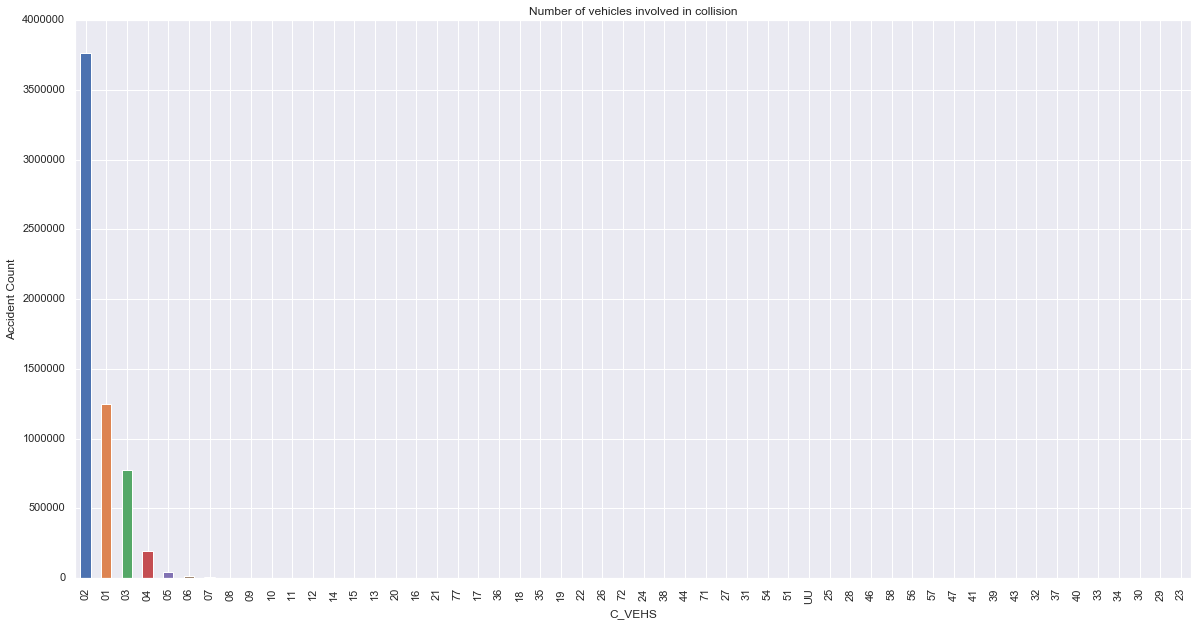

In [21]:
# Number of vehicles involved in collision
plotSimpleHist(df['C_VEHS'], 'Number of vehicles involved in collision', hight=10, width=20)
by_severity_count(df, 'C_VEHS', 'P_ISEV')

,01,02,03,04,05,06,21,22,23,24,25,31,32,33,34,35,36,41,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,,
non-fatal,26903.0,38072.0,24582.0,29853.0,1291.0,189226.0,928224.0,110080.0,24370.0,20134.0,5450.0,64475.0,21406.0,185034.0,27468.0,387021.0,241715.0,24552.0,104630.0,58795.0
injury,50006.0,116867.0,142433.0,188739.0,12071.0,346905.0,853604.0,96016.0,35657.0,26075.0,6662.0,125485.0,25685.0,235672.0,32600.0,480716.0,241094.0,34686.0,138736.0,83645.0
fatal,1388.0,2718.0,3939.0,4692.0,204.0,7049.0,2029.0,863.0,346.0,165.0,44.0,8979.0,664.0,1590.0,268.0,4524.0,1017.0,450.0,2269.0,969.0
N,1204.0,23271.0,1063.0,1300.0,192.0,216.0,68102.0,587.0,8083.0,6140.0,0.0,5879.0,592.0,21651.0,2411.0,40497.0,0.0,4535.0,14946.0,3713.0
U,1654.0,188.0,274.0,287.0,12.0,223.0,6031.0,166.0,766.0,484.0,17.0,673.0,263.0,1702.0,101.0,3642.0,174.0,445.0,255.0,1310.0


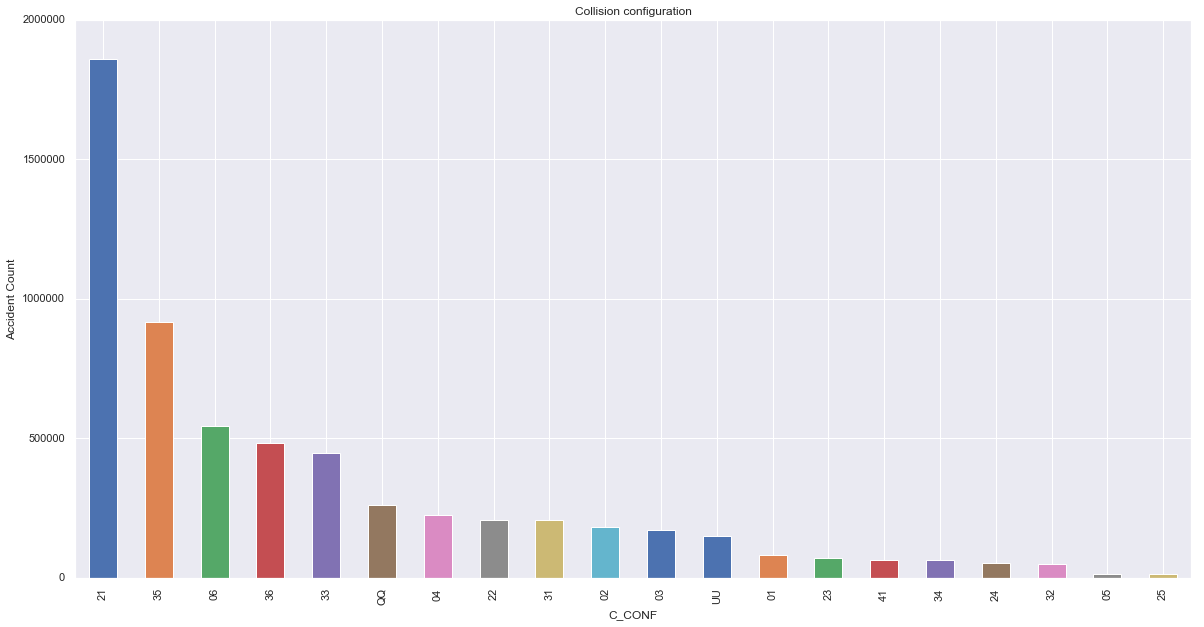

In [22]:
# Collision configuration
plotSimpleHist(df['C_CONF'], 'Collision configuration', hight=10, width=20)
by_severity_count(df, 'C_CONF', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,QQ,UU
Severity,,,,,,,,,,,,
non-fatal,829327.0,1282588.0,149258.0,4305.0,20784.0,2093.0,211.0,5250.0,774.0,139.0,38534.0,180018.0
injury,1289404.0,1487974.0,149464.0,13950.0,29072.0,3665.0,596.0,7044.0,1130.0,249.0,72037.0,218769.0
fatal,26399.0,10873.0,1178.0,453.0,570.0,76.0,38.0,46.0,6.0,6.0,1580.0,2942.0
N,75926.0,107809.0,93.0,5119.0,3612.0,580.0,21.0,26.0,193.0,4.0,9101.0,1898.0
U,7321.0,9445.0,117.0,18.0,322.0,0.0,3.0,35.0,12.0,5.0,817.0,572.0


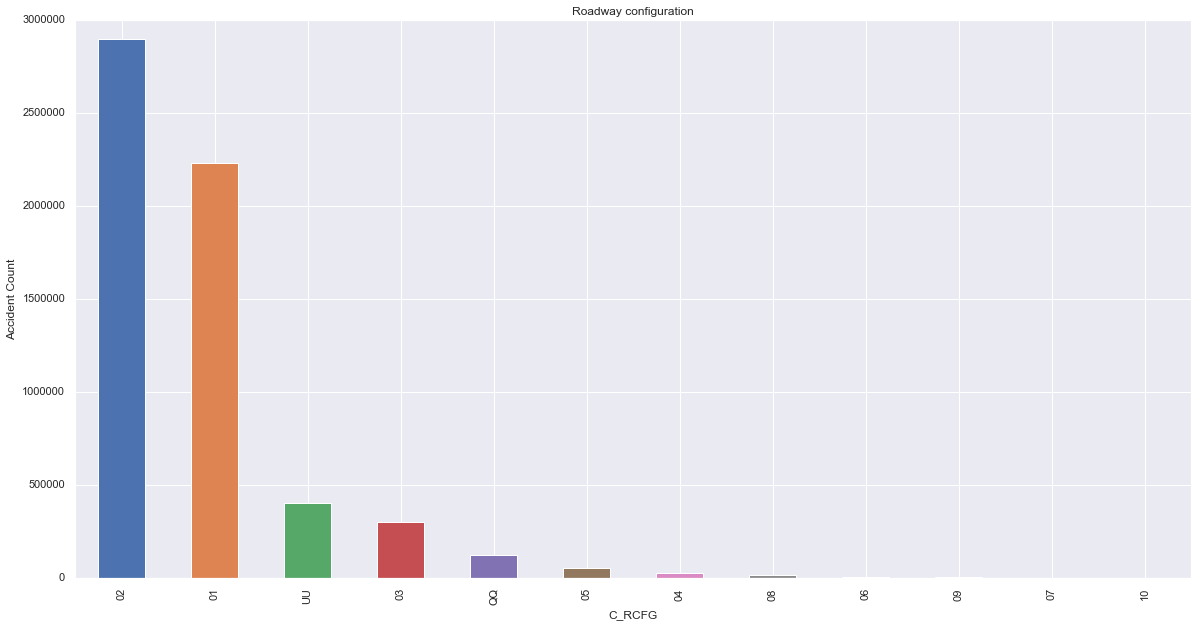

In [23]:
# Roadway configuration
plotSimpleHist(df['C_RCFG'], 'Roadway configuration', hight=10, width=20)
by_severity_count(df, 'C_RCFG', 'P_ISEV')

,1,2,3,4,5,6,7,Q,U
Severity,,,,,,,,,
non-fatal,1836030,207631,269328,140780,10557,28390,5256,5877,9432
injury,2272399,348821,330238,213118,19697,52681,10171,6605,19624
fatal,29669,5803,3666,2666,300,1240,249,127,447
N,126833,41754,19787,11046,731,3794,180,63,194
U,12259,3359,1663,1048,87,176,37,9,29


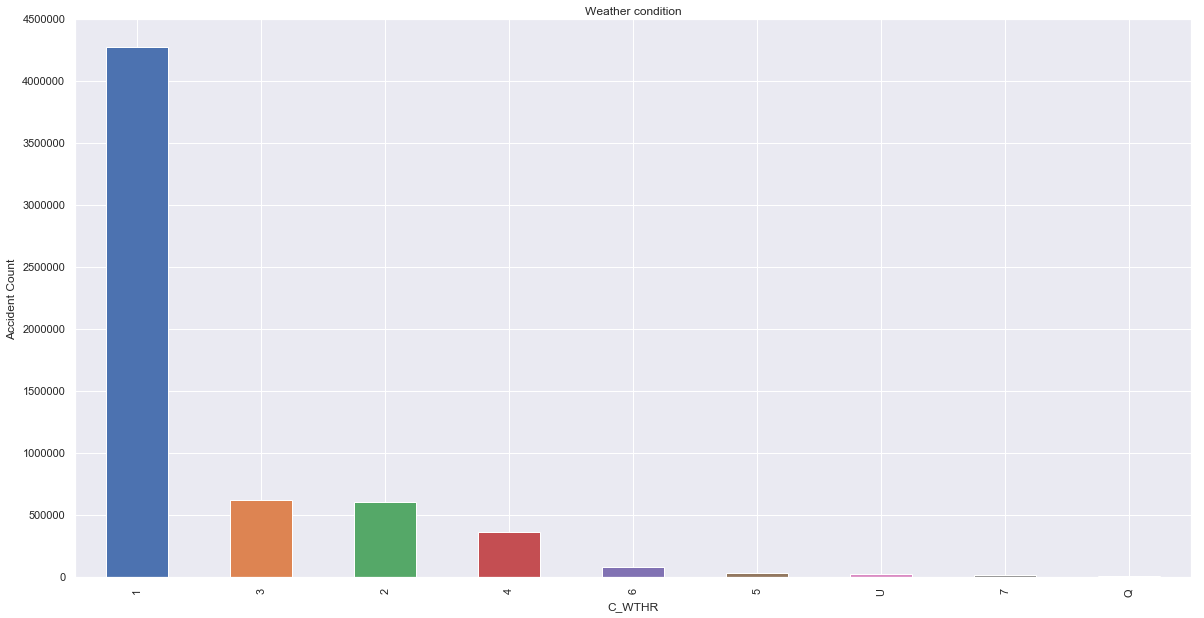

In [24]:
# Weather condition
plotSimpleHist(df['C_WTHR'], 'Weather condition', hight=10, width=20)
by_severity_count(df, 'C_WTHR', 'P_ISEV')

,1,2,3,4,5,6,7,8,9,Q,U
Severity,,,,,,,,,,,
non-fatal,1719454.0,479590.0,89934.0,28585.0,107362.0,4880.0,1462.0,315.0,79.0,72312.0,9308.0
injury,2143543.0,594951.0,157168.0,46954.0,204990.0,19547.0,3960.0,901.0,217.0,86971.0,14152.0
fatal,29799.0,6851.0,1876.0,623.0,2485.0,543.0,125.0,2.0,8.0,1446.0,409.0
N,134928.0,40957.0,16366.0,1071.0,10212.0,138.0,144.0,52.0,1.0,132.0,381.0
U,12787.0,3043.0,1289.0,72.0,976.0,27.0,37.0,3.0,0.0,383.0,50.0


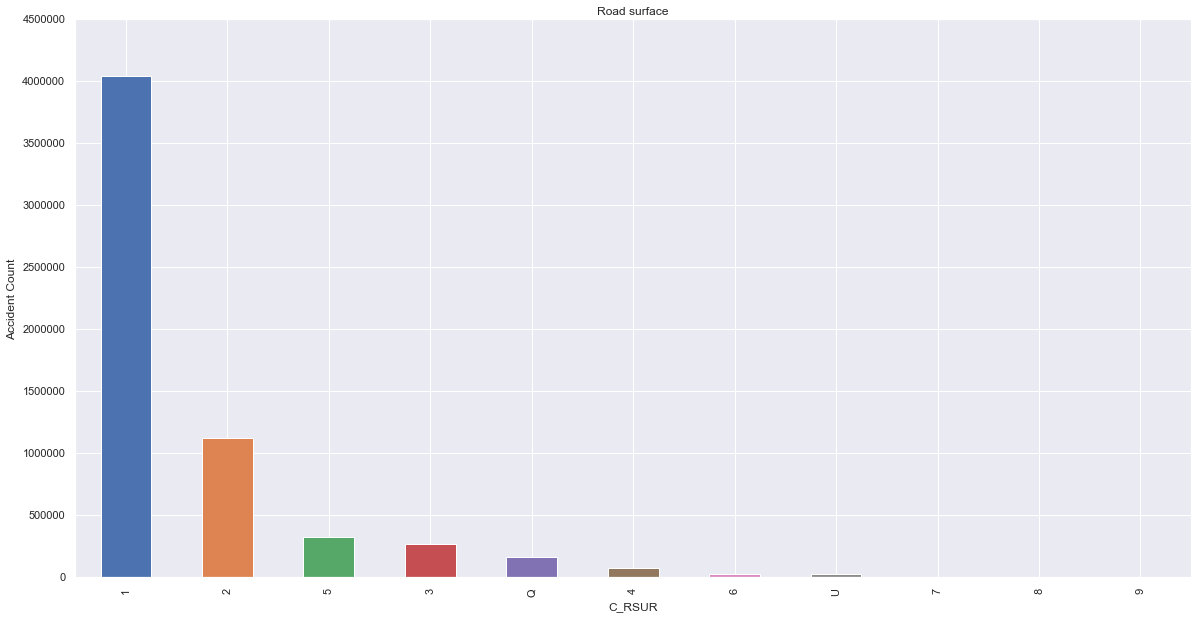

In [25]:
# Road surface
plotSimpleHist(df['C_RSUR'], 'Road surface', hight=10, width=20)
by_severity_count(df, 'C_RSUR', 'P_ISEV')

,1,2,3,4,5,6,Q,U
Severity,,,,,,,,
non-fatal,1875695.0,253580.0,108617.0,69776.0,13646.0,9023.0,3593.0,179351.0
injury,2312248.0,326791.0,253508.0,153605.0,25308.0,19024.0,9622.0,173248.0
fatal,25061.0,5282.0,6802.0,4359.0,560.0,453.0,161.0,1489.0
N,164632.0,20608.0,10377.0,5152.0,1826.0,1476.0,300.0,11.0
U,14191.0,2046.0,1098.0,640.0,66.0,48.0,0.0,578.0


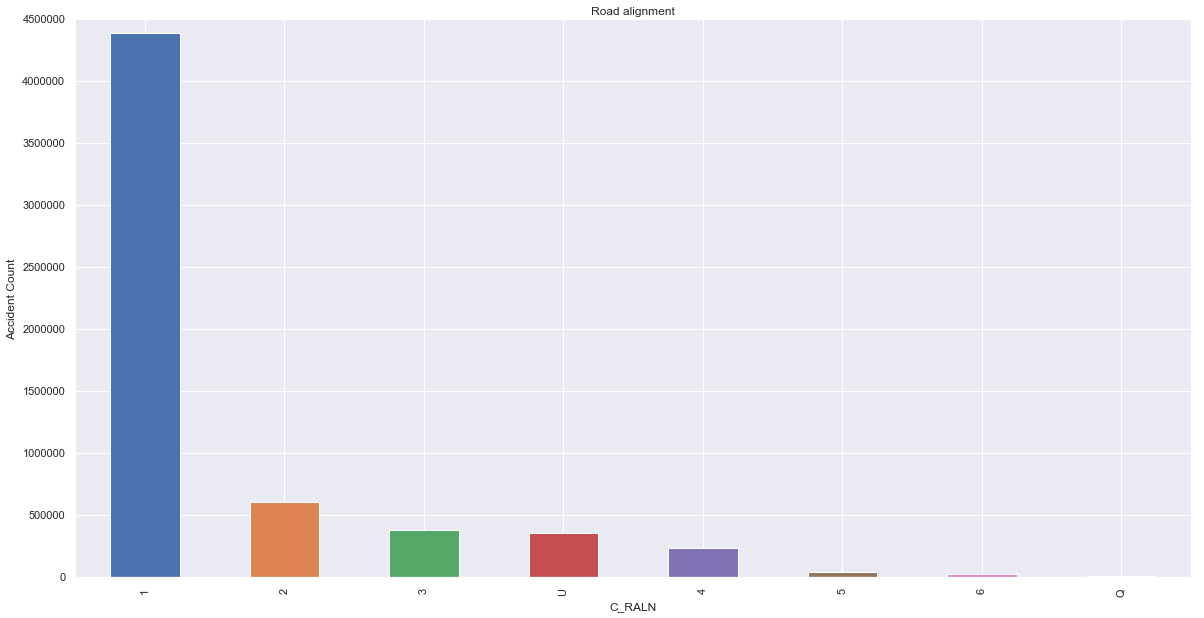

In [26]:
# Road alignment
plotSimpleHist(df['C_RALN'], 'Road alignment', hight=10, width=20)
by_severity_count(df, 'C_RALN', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,11,12,13,15,16,17,18,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,
non-fatal,816692.0,7877.0,302141.0,42668.0,856.0,22141.0,1157.0,12662.0,198.0,652.0,493.0,1056.0,2205.0,1169.0,213.0,1180.0,1211997.0,28121.0,59803.0
injury,855705.0,10803.0,362399.0,47190.0,2854.0,19930.0,1145.0,12271.0,300.0,1794.0,2253.0,1748.0,2067.0,2262.0,625.0,1651.0,1810042.0,35878.0,102437.0
fatal,3317.0,154.0,3512.0,223.0,82.0,169.0,10.0,69.0,1.0,66.0,73.0,59.0,11.0,107.0,51.0,35.0,33913.0,677.0,1638.0
N,53926.0,1394.0,22503.0,2237.0,369.0,945.0,0.0,588.0,42.0,108.0,387.0,15.0,274.0,154.0,7.0,0.0,116838.0,967.0,3628.0
U,4879.0,136.0,1945.0,260.0,12.0,103.0,37.0,1.0,6.0,24.0,47.0,11.0,30.0,6.0,0.0,25.0,10531.0,268.0,346.0


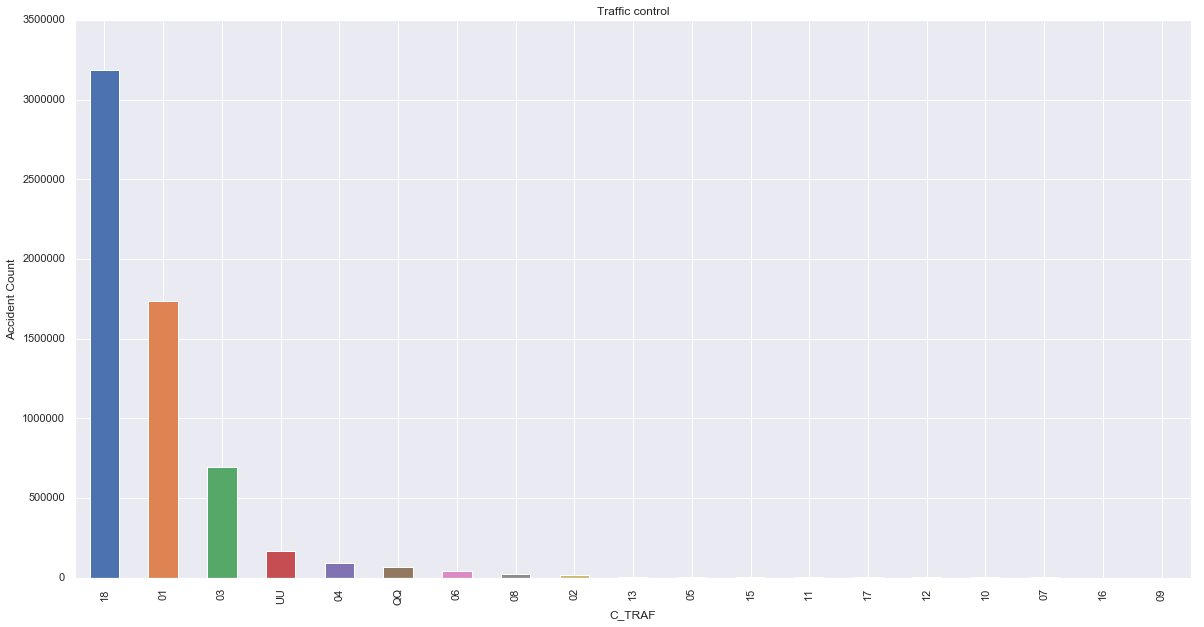

In [27]:
# Traffic control
plotSimpleHist(df['C_TRAF'], 'Traffic control', hight=10, width=20)
by_severity_count(df, 'C_TRAF', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,73,74,75,76,77,83,85,86,99,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1408184.0,856020.0,190474.0,39368.0,8649.0,2682.0,1133.0,620.0,447.0,258.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,3684.0,0.0
injury,1696714.0,1297746.0,97997.0,15268.0,3028.0,987.0,443.0,258.0,190.0,101.0,...,2.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,159792.0,0.0
fatal,28536.0,8890.0,400.0,82.0,36.0,9.0,5.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6167.0,7.0
N,114058.0,68505.0,15688.0,3745.0,1048.0,438.0,211.0,115.0,80.0,68.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
U,10097.0,6953.0,1194.0,261.0,67.0,28.0,14.0,10.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


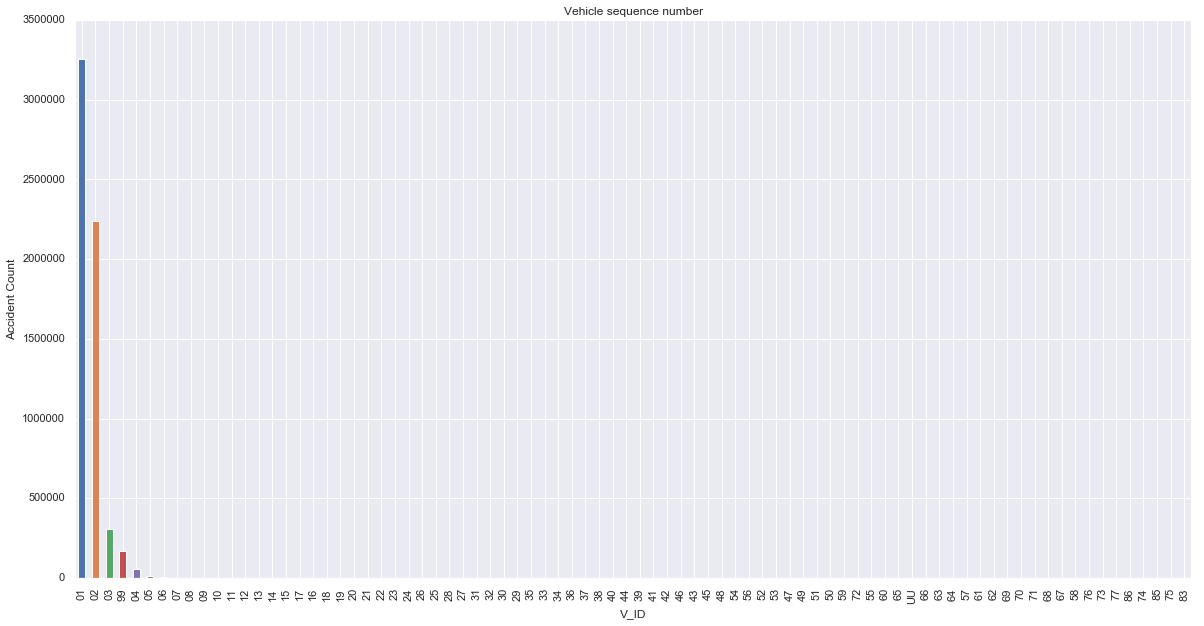

In [28]:
# Vehicle sequence number
# 99 = not a vehile
plotSimpleHist(df['V_ID'], 'Vehicle sequence number', hight=10, width=20)
by_severity_count(df, 'V_ID', 'P_ISEV')

,01,05,06,07,08,09,10,11,14,16,17,18,19,20,21,22,23,NN,QQ,UU
Severity,,,,,,,,,,,,,,,,,,,,
non-fatal,2196454.0,41255.0,88145.0,53002.0,41594.0,15261.0,625.0,30270.0,10891.0,1239.0,7927.0,1882.0,1249.0,3300.0,684.0,484.0,2347.0,4664.0,7759.0,4249.0
injury,2658575.0,28504.0,85602.0,28806.0,23072.0,6162.0,365.0,19928.0,118315.0,6789.0,114159.0,1253.0,581.0,1790.0,207.0,2835.0,884.0,160586.0,12331.0,2610.0
fatal,29317.0,316.0,1365.0,518.0,742.0,18.0,1.0,83.0,3487.0,456.0,1003.0,34.0,45.0,111.0,2.0,263.0,0.0,6194.0,164.0,48.0
N,179784.0,359.0,3454.0,6885.0,6426.0,938.0,1.0,3554.0,1658.0,62.0,228.0,16.0,0.0,975.0,0.0,37.0,0.0,5.0,0.0,0.0
U,14257.0,46.0,2524.0,675.0,610.0,54.0,0.0,222.0,105.0,17.0,14.0,25.0,3.0,94.0,1.0,10.0,0.0,2.0,8.0,0.0


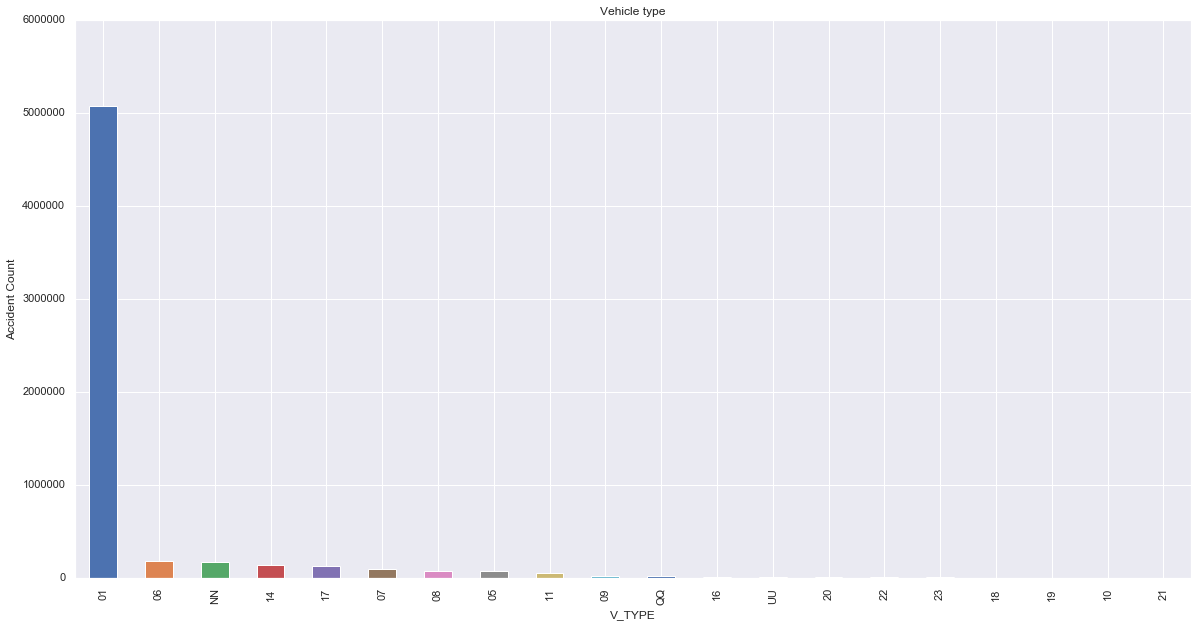

In [29]:
# Vehicle type
plotSimpleHist(df['V_TYPE'], 'Vehicle type', hight=10, width=20)
by_severity_count(df, 'V_TYPE', 'P_ISEV')

,1901,1903,1904,1905,1906,1907,1908,1909,1910,1911,...,2009,2010,2011,2012,2013,2014,2015,2016,NNNN,UUUU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,8.0,3.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,8.0,...,57832.0,56143.0,43657.0,38646.0,32997.0,24232.0,16833.0,7357.0,3976.0,85679.0
injury,6.0,5.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,2.0,...,68394.0,61362.0,44372.0,41043.0,35659.0,26206.0,17202.0,7348.0,199367.0,147896.0
fatal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,485.0,327.0,331.0,247.0,208.0,135.0,50.0,6510.0,2481.0
N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4674.0,4478.0,3215.0,2670.0,2241.0,1500.0,933.0,469.0,221.0,945.0
U,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,72.0,49.0,29.0,27.0,30.0,22.0,11.0,2.0,12.0,559.0


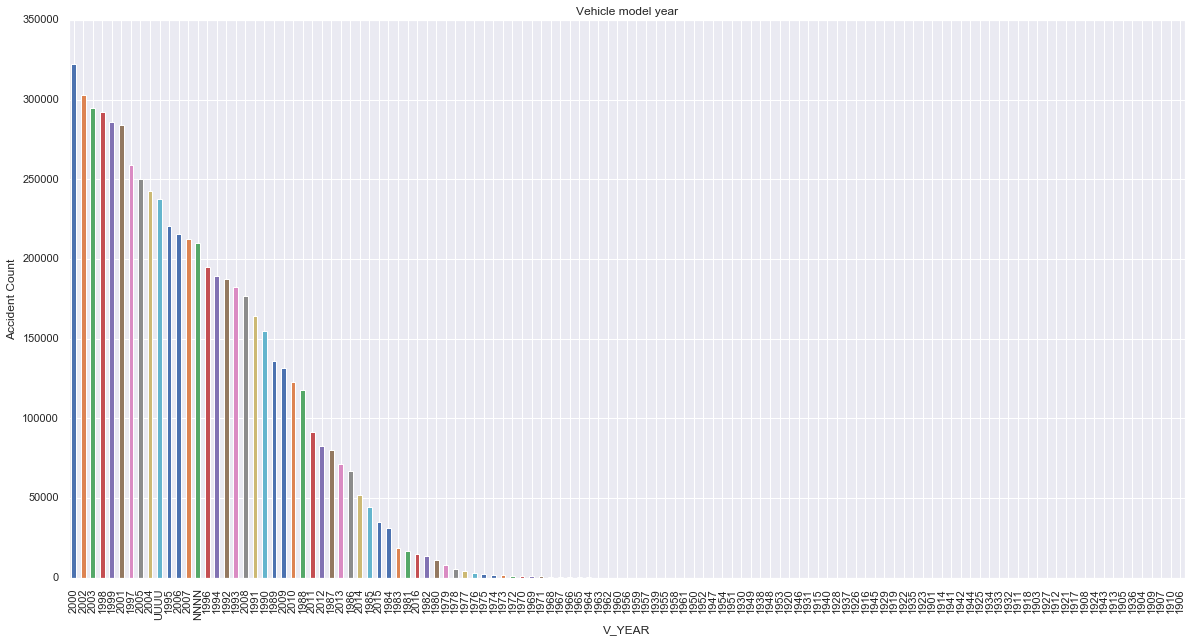

In [30]:
# Vehicle model year
plotSimpleHist(df['V_YEAR'], 'Vehicle model year', hight=10, width=20)
by_severity_count(df, 'V_YEAR', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,86,87,88,89,90,91,92,93,99,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,1733877.0,469845.0,187960.0,77770.0,24495.0,7031.0,2976.0,1397.0,926.0,735.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,5.0
injury,2317701.0,704557.0,164501.0,57740.0,17672.0,4864.0,1913.0,863.0,502.0,390.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,14.0
fatal,33613.0,7210.0,2081.0,794.0,308.0,89.0,31.0,13.0,9.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N,203026.0,1038.0,165.0,59.0,32.0,14.0,5.0,4.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
U,17574.0,645.0,260.0,114.0,36.0,13.0,5.0,3.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


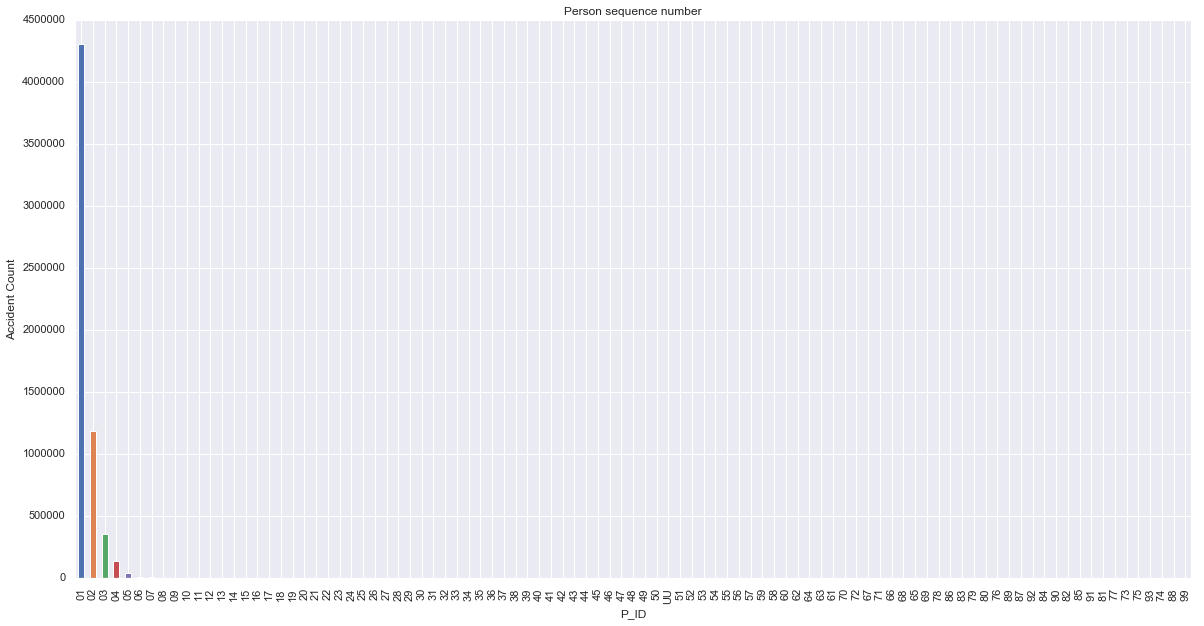

In [31]:
# Person sequence number
plotSimpleHist(df['P_ID'], 'Person sequence number', hight=10, width=20)
by_severity_count(df, 'P_ID', 'P_ISEV')

,F,M,N,U
Severity,,,,
non-fatal,895994.0,1586668.0,64.0,30555.0
injury,1656651.0,1587979.0,21.0,28703.0
fatal,13563.0,30543.0,0.0,61.0
N,46679.0,135644.0,0.0,22059.0
U,5023.0,13614.0,0.0,30.0


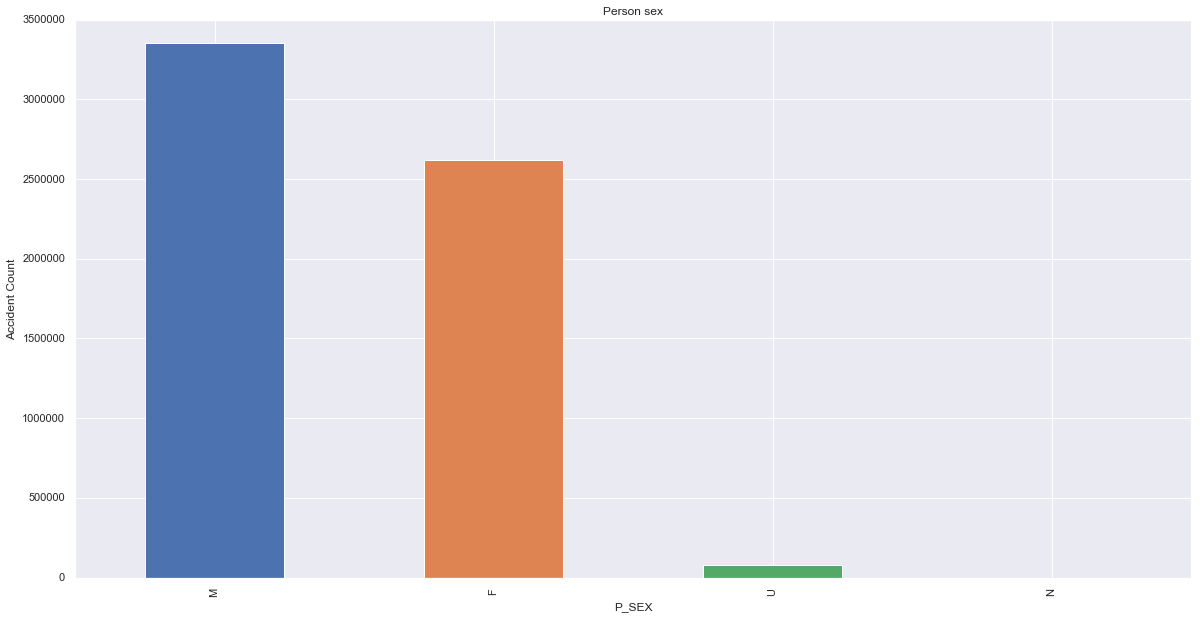

In [32]:
# Person sex
plotSimpleHist(df['P_SEX'], 'Person sex', hight=10, width=20)
by_severity_count(df, 'P_SEX', 'P_ISEV')

,01,02,03,04,05,06,07,08,09,10,...,92,93,94,95,96,97,98,99,NN,UU
Severity,,,,,,,,,,,,,,,,,,,,,
non-fatal,30604.0,19148.0,18351.0,17837.0,17070.0,15402.0,15086.0,14786.0,14369.0,14606.0,...,403.0,252.0,164.0,113.0,59.0,40.0,72.0,137.0,71.0,120078.0
injury,12958.0,8040.0,9059.0,10366.0,11325.0,12267.0,13350.0,13956.0,14552.0,15554.0,...,685.0,489.0,338.0,193.0,132.0,90.0,147.0,142.0,1821.0,87811.0
fatal,158.0,73.0,74.0,100.0,104.0,101.0,106.0,94.0,111.0,113.0,...,53.0,40.0,25.0,20.0,13.0,7.0,6.0,8.0,5.0,268.0
N,20.0,4.0,8.0,5.0,11.0,13.0,13.0,16.0,12.0,17.0,...,26.0,10.0,5.0,8.0,1.0,1.0,2.0,3.0,0.0,668.0
U,65.0,26.0,23.0,17.0,16.0,10.0,22.0,12.0,14.0,14.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,281.0


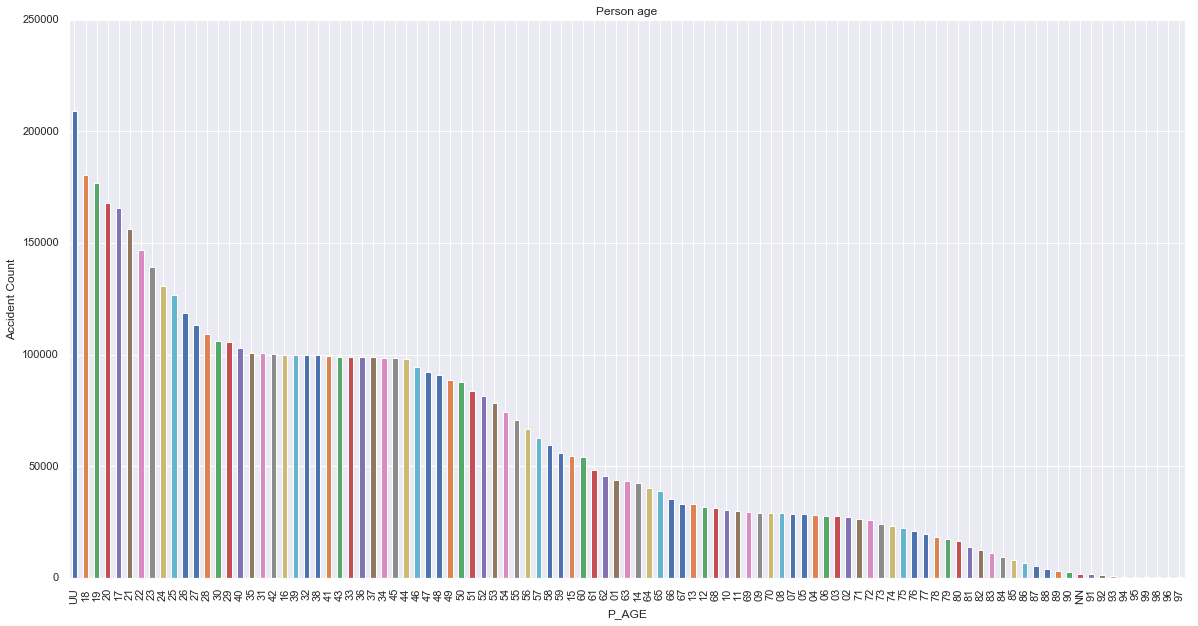

In [33]:
# Person age
plotSimpleHist(df['P_AGE'], 'Person age', hight=10, width=20)
by_severity_count(df, 'P_AGE', 'P_ISEV')

,11,12,13,21,22,23,31,32,33,96,97,98,99,NN,QQ,UU
Severity,,,,,,,,,,,,,,,,
non-fatal,1737686.0,32538.0,375851.0,122782.0,51944.0,148722.0,2835.0,17344.0,3444.0,10766.0,117.0,1021.0,3644.0,25.0,1753.0,2809.0
injury,2140914.0,58348.0,568015.0,109704.0,43129.0,129652.0,2041.0,14413.0,2744.0,31181.0,158.0,5106.0,159781.0,59.0,2677.0,5432.0
fatal,26745.0,598.0,5862.0,1344.0,501.0,1293.0,35.0,217.0,36.0,1019.0,4.0,116.0,6167.0,10.0,60.0,160.0
N,203854.0,8.0,190.0,42.0,11.0,57.0,8.0,4.0,11.0,93.0,1.0,10.0,0.0,2.0,91.0,0.0
U,17576.0,92.0,492.0,128.0,56.0,141.0,15.0,18.0,15.0,126.0,0.0,3.0,1.0,0.0,4.0,0.0


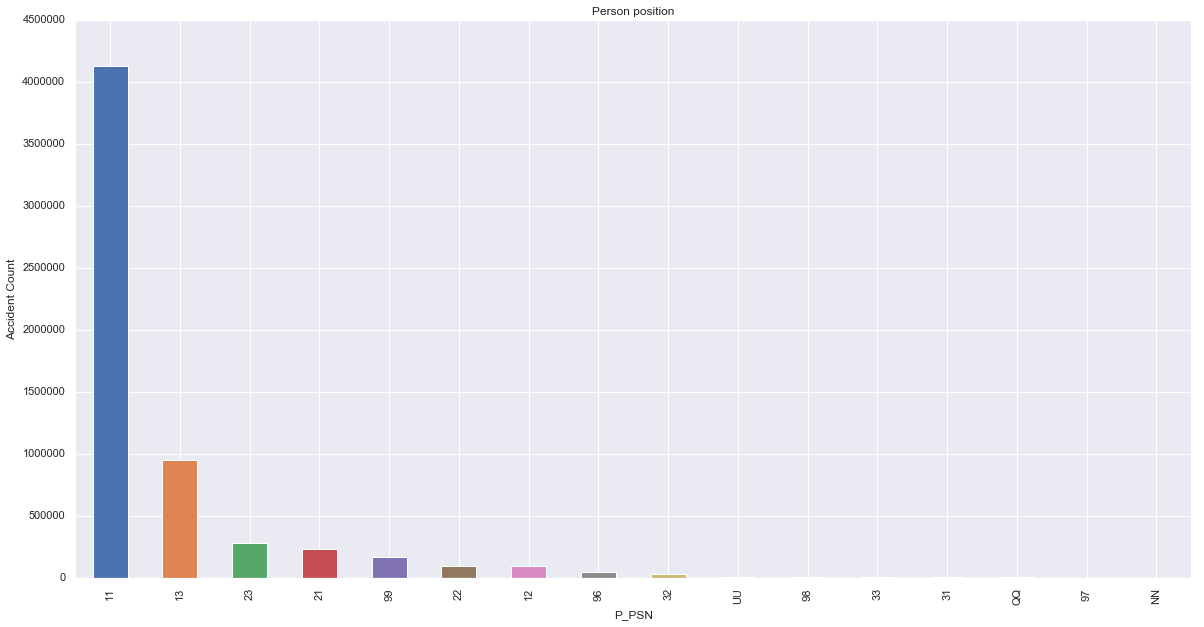

In [34]:
# Person position
plotSimpleHist(df['P_PSN'], 'Person position', hight=10, width=20)
by_severity_count(df, 'P_PSN', 'P_ISEV')

,01,02,09,10,11,12,13,NN,QQ,UU
Severity,,,,,,,,,,
non-fatal,31800.0,1994042.0,3562.0,8.0,3.0,4977.0,31894.0,160442.0,11102.0,275451.0
injury,155793.0,2532572.0,103869.0,131.0,9.0,20578.0,119235.0,109022.0,39217.0,192928.0
fatal,11106.0,18127.0,2955.0,13.0,1.0,348.0,2315.0,3657.0,723.0,4922.0
N,10.0,279.0,3.0,0.0,1.0,0.0,0.0,182192.0,0.0,21897.0
U,156.0,1820.0,9.0,0.0,0.0,2.0,35.0,11.0,2.0,16632.0


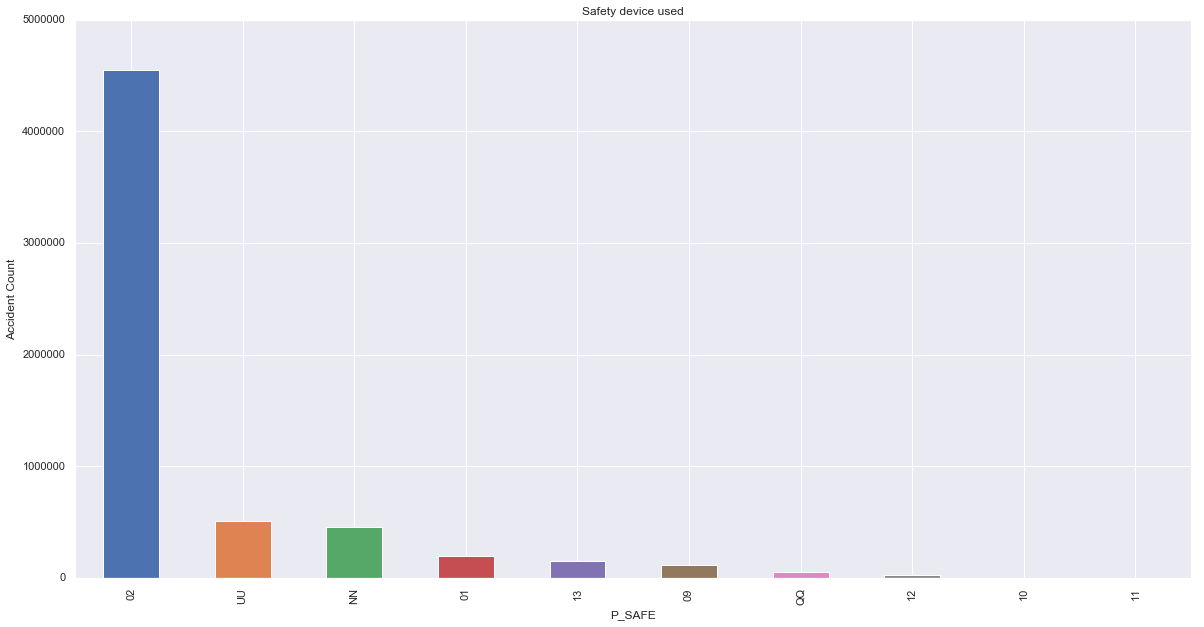

In [35]:
# Safety device used
plotSimpleHist(df['P_SAFE'], 'Safety device used', hight=10, width=20)
by_severity_count(df, 'P_SAFE', 'P_ISEV')

,1,2,3,4,5,U
Severity,,,,,,
non-fatal,1707581.0,758594.0,3684.0,7927.0,10891.0,24604.0
injury,1931514.0,911170.0,159792.0,114159.0,118315.0,38404.0
fatal,22322.0,9787.0,6167.0,1003.0,3487.0,1401.0
N,200962.0,422.0,0.0,228.0,1658.0,1112.0
U,17343.0,1064.0,1.0,14.0,105.0,140.0


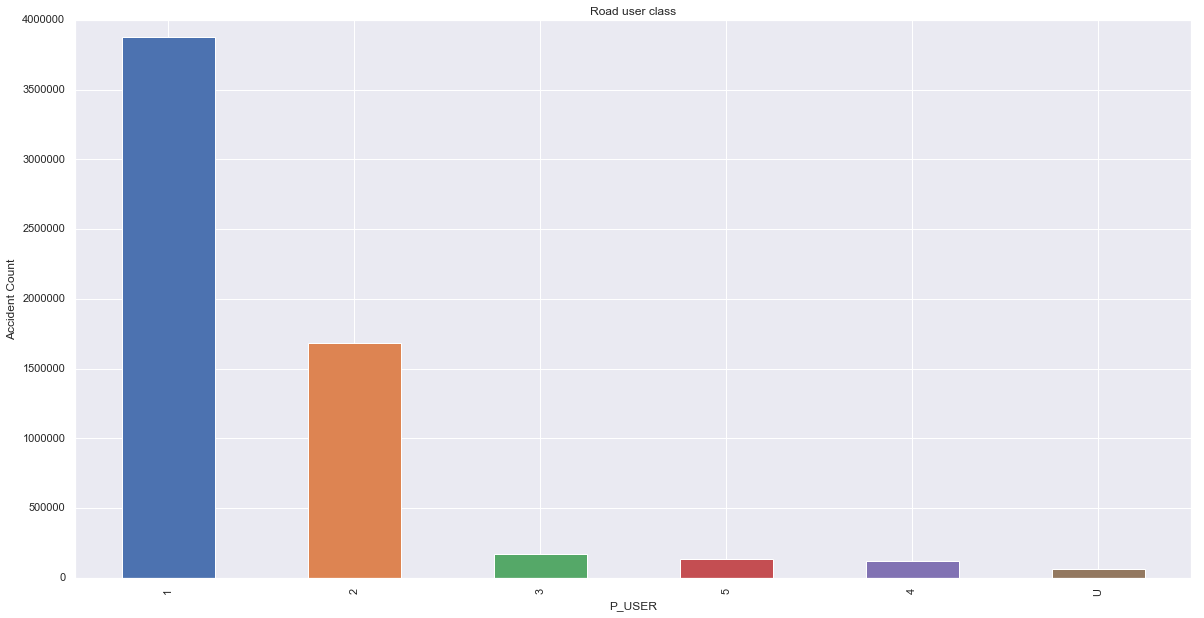

In [36]:
# Road user class
plotSimpleHist(df['P_USER'], 'Road user class', hight=10, width=20)
by_severity_count(df, 'P_USER', 'P_ISEV')

### Copy dataset

In [39]:
dfcopy2 = df.copy()

## Clean dataset

#### Clean: P_ISEV

Severity,injury,non-fatal,N,fatal,U,5
Count,3273354,2513281,204382,44167,18666,1


Severity,injury,non-fatal,fatal,5
Count,3273354,2513281,44167,1


Dropped 223048 rows from dataset


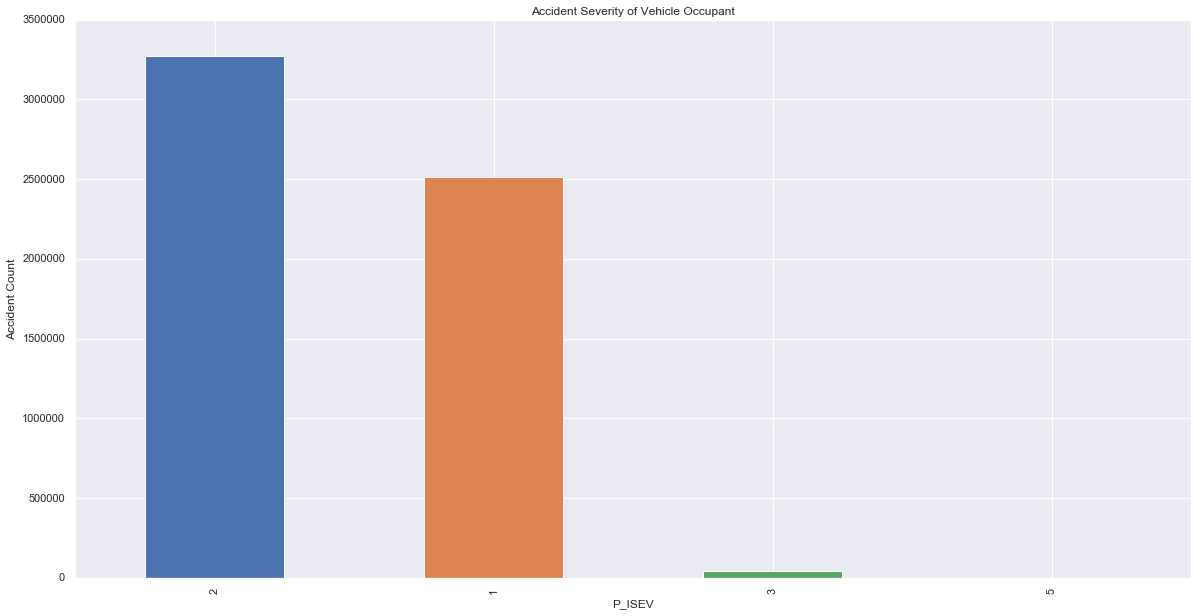

In [62]:
#P_ISEV
display(severity_count(df['P_ISEV']).transpose())
drop_count = df['P_ISEV'].isin(['U', 'N',]).sum()
df.drop(df.index[df['P_ISEV'].isin(['U', 'N'])], inplace=True)
df = df.reset_index(drop=True)
display(severity_count(df['P_ISEV']).transpose())
plotSimpleHist(df['P_ISEV'], 'Accident Severity of Vehicle Occupant', hight=10, width=20)
print("Dropped {drop_count} rows from dataset".format(drop_count = drop_count))

#### Clean: C_YEAR

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Severity,,,,,,,,,,,,,,,,,,
non-fatal,164530,164422,159174,163251,156230,149797,148269,144475,140466,129562,127212,130351,127214,125985,125395,116694,122013,118241
injury,210201,214626,208485,214309,207481,198071,196115,191593,184957,169683,164400,165717,162012,161166,159124,151030,155895,158489
fatal,2980,2904,2758,2921,2777,2735,2898,2871,2753,2431,2216,2238,2023,2075,1951,1846,1895,1895


0 non-numeric rows observed


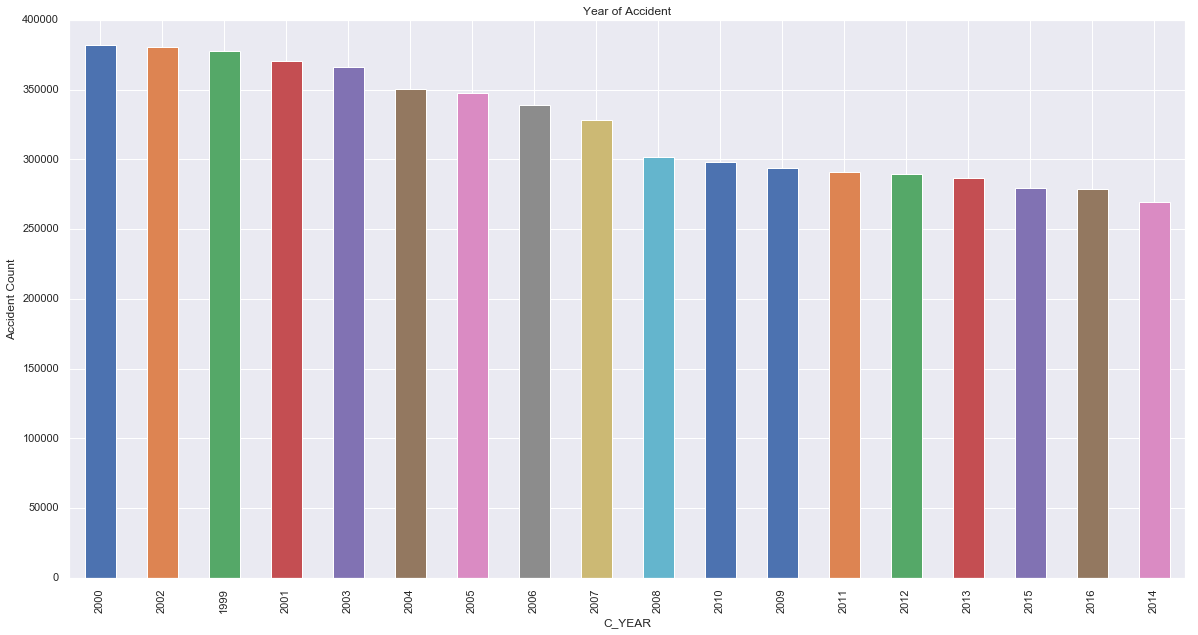

In [47]:
#C_YEAR
display(by_severity_count(df, 'C_YEAR', 'P_ISEV'))
plotSimpleHist(df['C_YEAR'], 'Year of Accident', hight=10, width=20)
print("{count} non-numeric rows observed".format(count = df['C_YEAR'].astype('str').str.contains('[^0-9]').sum()))

#### Clean: C_MNTH

,01,02,03,04,05,06,07,08,09,10,11,12,UU
Severity,,,,,,,,,,,,,
non-fatal,212435,183172,178228,169478,202060,222236,230921,234464,221662,222973,211278,224349,25
injury,278984,237052,231489,219548,261624,291477,302132,305355,284231,286927,281763,292745,27
fatal,3140,2649,2744,2924,3593,3973,4573,4663,4194,4133,3803,3775,3


42110 non-numeric rows observed
0 non-numeric rows observed


,01,02,03,04,05,06,07,08,09,10,11,12
Severity,,,,,,,,,,,,
non-fatal,212435,183172,178228,169478,202060,222236,230921,234464,221687,222973,211278,224349
injury,278984,237052,231489,219548,261624,291477,302132,305355,284258,286927,281763,292745
fatal,3140,2649,2744,2924,3593,3973,4573,4663,4197,4133,3803,3775


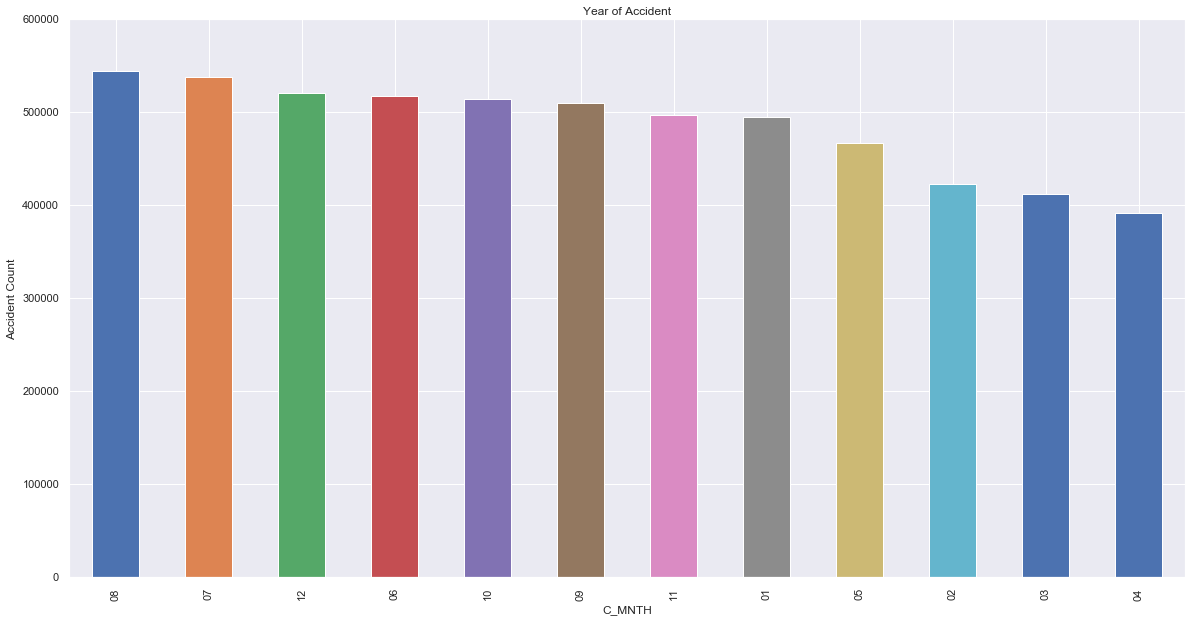

In [55]:
display(by_severity_count(df, 'C_MNTH', 'P_ISEV'))
print("{count} non-numeric rows observed".format(count = df['C_WTHR'].astype('str').str.contains('[^0-9]').sum()))
gbC_MNTH = checkHistogram(df, 'C_MNTH', 'P_ISEV', False)
P = computeP(gbC_MNTH)
data_to_impute = df['C_MNTH'].astype('str').str.contains('UU')
df[data_to_impute] = df.loc[data_to_impute].apply(lambda x: x.replace('UU', selectBin(1, 13, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))
plotSimpleHist(df['C_MNTH'], 'Accident Month', hight=10, width=20)
display(by_severity_count(df, 'C_MNTH', 'P_ISEV'))

#### Clean: C_WDAY

,1,2,3,4,5,6,7,U
Severity,,,,,,,,
non-fatal,330245.0,351875.0,354918.0,372770.0,433602.0,373642.0,295976.0,253.0
injury,438258.0,456197.0,459456.0,484191.0,550542.0,481990.0,402287.0,433.0
fatal,5466.0,5260.0,5459.0,6100.0,7186.0,7807.0,6881.0,8.0
N,26833.0,29445.0,30039.0,33314.0,36687.0,26323.0,21741.0,0.0
U,2499.0,2605.0,2608.0,2848.0,3469.0,2543.0,2094.0,1.0


695 non-numeric rows observed
0 non-numeric rows observed


,1,2,3,4,5,6,7
Severity,,,,,,,
non-fatal,330245.0,352128.0,354918.0,372770.0,433602.0,373642.0,295976.0
injury,438258.0,456630.0,459456.0,484191.0,550542.0,481990.0,402287.0
fatal,5466.0,5268.0,5459.0,6100.0,7186.0,7807.0,6881.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
N,26833.0,29445.0,30039.0,33314.0,36687.0,26323.0,21741.0
U,2499.0,2605.0,2608.0,2848.0,3469.0,2543.0,2094.0


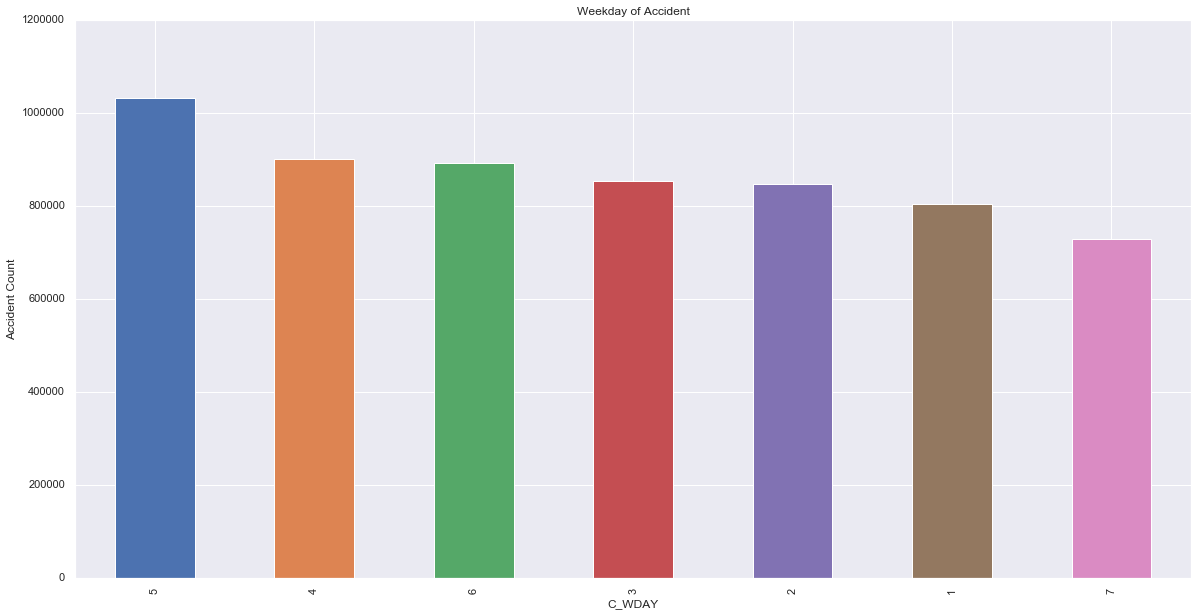

In [61]:
# C_WDAY
display(by_severity_count(df, 'C_WDAY', 'P_ISEV')) 
cleanData(df, 'C_WDAY', 'P_ISEV', ['U'], 1, 8, False)
plotSimpleHist(df['C_WDAY'], 'Weekday of Accident', hight=10, width=20)
display(by_severity_count(df, 'C_WDAY', 'P_ISEV'))

#### Clean: C_HOUR

In [ ]:
#C_HOUR
display(by_severity_count(df, 'C_HOUR', 'P_ISEV')) 
#cleanData(df, 'C_HOUR', 'P_ISEV', ['U'], 1, 25, True)
plotSimpleHist(df['C_HOUR'], 'Time of Accident', hight=10, width=20)
display(by_severity_count(df, 'C_HOUR', 'P_ISEV'))

In [42]:
'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG',
       'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR',
       'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_SAFE', 'P_USER', 'P_ISEV'],
      dtype='object')

Index(['C_YEAR', 'C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG',
       'C_WTHR', 'C_RSUR', 'C_RALN', 'C_TRAF', 'V_ID', 'V_TYPE', 'V_YEAR',
       'P_ID', 'P_SEX', 'P_AGE', 'P_PSN', 'P_SAFE', 'P_USER', 'P_ISEV'],
      dtype='object')


In [ ]:
#P_xxx
display(by_severity_count(df, 'C_MNTH', 'P_ISEV'))
print("{count} non-numeric rows observed".format(count = df['C_WTHR'].astype('str').str.contains('[^0-9]').sum()))
gbC_MNTH = checkHistogram(df, 'C_MNTH', 'P_ISEV', False)
P = computeP(gbC_MNTH)
data_to_impute = df['C_MNTH'].astype('str').str.contains('UU')
df[data_to_impute] = df.loc[data_to_impute].apply(lambda x: x.replace('UU', selectBin(1, 13, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))
plotSimpleHist(df['C_MNTH'], 'Year of Accident', hight=10, width=20)
display(by_severity_count(df, 'C_MNTH', 'P_ISEV'))

### Clean intividual attributes

In [ ]:
#### Clean Accident Year column

#Collisions by Year
print("{count} non-numeric rows observed".format(count = df['C_YEAR'].astype('str').str.contains('[^0-9]').sum()))
by_year = df.groupby(['C_YEAR','P_ISEV']).size()
plt_enabled = False
if (plt_enabled):
    plot = by_year.plot(figsize=(20,15), kind='bar',title='Collisions by Year');




In [ ]:
#### Clean Accident month column
#import random


#Collisions by Month
print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))
by_month = df.groupby(['C_MNTH','P_ISEV']).size()
plt_enabled = False
if (plt_enabled):
    plot = by_month.plot(figsize=(20,15), kind='bar',title='Collisions by Year');

tmp = df.index[df['C_MNTH'].astype('str').str.contains('[^0-9]')]
    
## Not much variations accross the months, we are going to randomly (with equal probability)
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

df['C_MNTH'] = df['C_MNTH'].apply(lambda x: x.replace('UU', np.random.choice(months)))

print("{count} non-numeric rows observed".format(count = df['C_MNTH'].astype('str').str.contains('[^0-9]').sum()))



In [ ]:
#### Clean Accident Week column

#Collisions by weekday
print("{count} non-numeric rows observed".format(count = df['C_WDAY'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_WDAY','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by Weekday', stacked = True);

#generate the probability of each row excluding unspecified
#Total number of rows excluding undefined


In [ ]:
N = by_weekday[0:len(by_weekday.index) - 1].sum().sum()
P=[]
for day in by_weekday.index[0:len(by_weekday.index) - 1]:
    #print(day)
    p = by_weekday.loc[day].sum()/N
    P.append(p)
    #print(P)
df['C_WDAY'] = df['C_WDAY'].apply(lambda x: x.replace('U', str(np.random.choice(np.arange(1, 8), p = P))))
print("{count} non-numeric rows observed".format(count = df['C_WDAY'].astype('str').str.contains('[^0-9]').sum()))

In [ ]:
#### Clean Accident Hour column

#Collisions by weekday
print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_HOUR','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);

#To many levels, lets reduce the number of levels by combining the hours
#[8pm-6am], [7am-7pm]
night = ['22', '23', '00', '01', '02', '03', '04', '05']
morning = ['06', '07', '08', '09', '10', '11']
activeHours = ['12', '13', '14', '15', '16', '17', '18', '19', '20', '21'] 

#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
#df['C_HOUR'] = df['C_HOUR'].apply(lambda x: x.replace(Night, '1'))
df['C_HOUR'] = df['C_HOUR'].apply(lambda x: '1' if x in night else '2' if x in morning else '3')
print("{count} non-numeric rows observed".format(count = df['C_HOUR'].astype('str').str.contains('[^0-9]').sum()))

if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions by HOUR', stacked = False);


In [ ]:
#### Clean Accident Vehicle count column

#Collisions severity by Vehicle count
print("{count} non-numeric rows observed".format(count = df['C_VEHS'].astype('str').str.contains('[^0-9]').sum()))
by_weekday = df.groupby(['C_VEHS','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions severity by Vehicle count', stacked = True);

In [ ]:
#### Clean Accident Collison Configuration column

#Collisions severity by Collison Configuration
print("{count} non-numeric rows observed".format(count = df['C_CONF'].astype('str').str.contains('[^0-9]').sum()))
by_CCONF = df.groupby(['C_CONF','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_weekday.plot(figsize=(20,15), kind='bar',title='Collisions severity by Collison Configuration', stacked = False);
print(by_CCONF)

In [ ]:
#functions
debug2 = False

def selectBin(start, end, P, leadingZero = False):
    x = np.random.choice(np.arange(start, end), p = P)
    if debug2:
        print("Selected bin: {0}".format(x))
    if leadingZero:
        if x < 10:
            x = '0' + str(x)
    return str(x)

#compute the probability of each bin
def computeP(dataFrm):
    N = dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')].sum().sum()
    if debug:
        print(dataFrm[dataFrm.index.astype('str').str.contains('[0-9]')])
        print(N)
    
    maxCol = dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')].max()

    #calculate the probability of the each category
    P=[]
    cur = 1;
    for ind in dataFrm.index[dataFrm.index.astype('str').str.contains('[0-9]')]:
        if debug:
            print("ind: {0}".format(ind))
            print("cur: {0}".format(cur))
            
        # some categoris may not have any values
        # we need to build the P matrix for the same number of colums
        end = int(ind)
        if cur < end:
            for i in range(cur, end):
                print("i: {0}".format(i))
                P.append(0)
                cur = cur +1
                
        p = dataFrm.loc[ind].sum()/N
        P.append(p)
        cur = cur +1
    
    if debug:
        print(P)
        print(np.sum(P))
    
    return P      

#plot histogram
def checkHistogram(df, feature, pred, plot):
    by_level = df.groupby([feature,pred]).size().unstack()

    if(plot):
        plot = by_level.plot(figsize=(20,15), kind='bar',title='Weather Configuration', stacked = False);
            
    return by_level


In [ ]:
#Clean Road configuraiton
print("{count} non-numeric rows observed".format(count = df['C_RCFG'].astype('str').str.contains('[^0-9]').sum()))
by_road_config = df.groupby(['C_RCFG','P_ISEV']).size().unstack()
plt_enabled = True
if (plt_enabled):
    plot = by_road_config.plot(figsize=(20,15), kind='bar',title='Road Configuration', stacked = False);

N = by_road_config[0:len(by_road_config.index) - 2].sum().sum()
N1 = by_road_config[0:len(by_road_config.index) - 1].sum()
print (N)
#calculate the probability of the each category
P=[]
for cfg in by_road_config.index[0:len(by_road_config.index) - 2]:
    #print(cfg)
    p = by_road_config.loc[cfg].sum()/N
    P.append(p)
    #print(P)
np.sum(P)
#df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('UU', str(np.random.choice(np.arange(1, 11), p = P))))
df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('UU', selectBin(1, 11, P, True)))
#df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('QQ', str(np.random.choice(np.arange(1, 11), p = P))))
df['C_RCFG'] = df['C_RCFG'].apply(lambda x: x.replace('QQ', selectBin(1, 11, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_RCFG'].astype('str').str.contains('[^0-9]').sum()))

In [ ]:
by_road_config = df.groupby(['C_RCFG','P_ISEV']).size().unstack()
plt_enabled = False
if (plt_enabled):
    plot = by_road_config.plot(figsize=(20,15), kind='bar',title='Road Configuration', stacked = False);


In [ ]:
#Clean Weather
#C_WTHR

print("{count} non-numeric rows observed".format(count = df['C_WTHR'].astype('str').str.contains('[^0-9]').sum()))
gbWTHR = checkHistogram(df, 'C_WTHR', 'P_ISEV', True)

In [ ]:
#compute probability of each level not including unknows
P = computeP(gbWTHR)

In [ ]:
#impute unkown values
df['C_WTHR'] = df['C_WTHR'].apply(lambda x: x.replace('Q', selectBin(1, 8, P, False)))
df['C_WTHR'] = df['C_WTHR'].apply(lambda x: x.replace('U', selectBin(1, 8, P, False)))
print("{count} non-numeric rows observed".format(count = df['C_WTHR'].astype('str').str.contains('[^0-9]').sum()))

In [ ]:
#check histogram for new distribution
checkHistogram(df, 'C_WTHR', 'P_ISEV', True)

In [ ]:
#Clean road surface
#C_RSUR
print("{count} non-numeric rows observed".format(count = df['C_RSUR'].astype('str').str.contains('[^0-9]').sum()))
gbRSUR = checkHistogram(df, 'C_RSUR', 'P_ISEV', True)

In [ ]:
#compute probability of each road surface condition in our data set not including unknows
P = computeP(gbRSUR)

In [ ]:
#impute unkown values
df['C_RSUR'] = df['C_RSUR'].apply(lambda x: x.replace('Q', selectBin(1, 10, P, False)))
df['C_RSUR'] = df['C_RSUR'].apply(lambda x: x.replace('U', selectBin(1, 10, P, False)))
print("{count} non-numeric rows observed".format(count = df['C_RSUR'].astype('str').str.contains('[^0-9]').sum()))

In [ ]:
#Clean road surface
print("{count} non-numeric rows observed".format(count = df['C_RSUR'].astype('str').str.contains('[^0-9]').sum()))
checkHistogram(df, 'C_RSUR', 'P_ISEV', True)

In [ ]:
#road alignment
#C_RALN
print("{count} non-numeric rows observed".format(count = df['C_RALN'].astype('str').str.contains('[^0-9]').sum()))
gbRALG = checkHistogram(df, 'C_RALN', 'P_ISEV', True)

In [ ]:
#compute probability of each road alignment in our data set not including unknows
P = computeP(gbRALG)

#impute unkown values
df['C_RALN'] = df['C_RALN'].apply(lambda x: x.replace('Q', selectBin(1, 7, P, False)))
df['C_RALN'] = df['C_RALN'].apply(lambda x: x.replace('U', selectBin(1, 7, P, False)))
print("{count} non-numeric rows observed".format(count = df['C_RALN'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'C_RALN', 'P_ISEV', True)

In [ ]:
df.dtypes

In [ ]:
#C_TRAF
#Traffic configuration
print("{count} non-numeric rows observed".format(count = df['C_TRAF'].astype('str').str.contains('[^0-9]').sum()))
gbTRAF = checkHistogram(df, 'C_TRAF', 'P_ISEV', True)

In [ ]:
#compute probability of each road alignment in our data set not including unknows
#note, school bus zone has no value
P = computeP(gbTRAF)

#impute unkown values
df['C_TRAF'] = df['C_TRAF'].apply(lambda x: x.replace('QQ', selectBin(1, 19, P, True)))
df['C_TRAF'] = df['C_TRAF'].apply(lambda x: x.replace('UU', selectBin(1, 19, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_TRAF'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'C_TRAF', 'P_ISEV', True)

In [ ]:
df.columns

In [ ]:
#vehicle if
print("{count} non-numeric rows observed".format(count = df['V_ID'].astype('str').str.contains('[^0-9]').sum()))
gbVID = checkHistogram(df, 'V_ID', 'P_ISEV', True)

In [ ]:
#compute probability of each road alignment in our data set not including unknows
#note, school bus zone has no value
P = computeP(gbVID)

#impute unkown values
df['V_ID'] = df['V_ID'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['C_TRAF'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'V_ID', 'P_ISEV', True)

In [ ]:
#V_TYPE
#change NN to 24
df['V_TYPE'] = df['V_TYPE'].apply(lambda x: x.replace('NN', '24'))

print("{count} non-numeric rows observed".format(count = df['V_TYPE'].astype('str').str.contains('[^0-9]').sum()))
gbVTYPE = checkHistogram(df, 'V_TYPE', 'P_ISEV', True)

In [ ]:
#compute probability of each road alignment in our data set not including unknows
#note, school bus zone has no value
P = computeP(gbVTYPE)

#impute unkown values
df['V_TYPE'] = df['V_TYPE'].apply(lambda x: x.replace('UU', selectBin(1, 25, P, True)))
df['V_TYPE'] = df['V_TYPE'].apply(lambda x: x.replace('QQ', selectBin(1, 25, P, True)))
print("{count} non-numeric rows observed".format(count = df['V_TYPE'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'V_TYPE', 'P_ISEV', True)

In [ ]:
#V_YEAR - Vehicle Year
df['V_YEAR'] = df['V_YEAR'].apply(lambda x: x.replace('NNNN', '2017'))

#For now set UUUU to year 2018, unti we find out why the code is not working
df['V_YEAR'] = df['V_YEAR'].apply(lambda x: x.replace('UUUU', '2018'))

print("{count} non-numeric rows observed".format(count = df['V_YEAR'].astype('str').str.contains('[^0-9]').sum()))
gbVYEAR = checkHistogram(df, 'V_YEAR', 'P_ISEV', True)

In [ ]:
P = computeP(gbVYEAR)

#impute unkown values
#df['V_YEAR'] = df['V_YEAR'].apply(lambda x: x.replace('UUUU', selectBin(1, 118, P, True)))
#print("{count} non-numeric rows observed".format(count = df['V_YEAR'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
#checkHistogram(df, 'V_YEAR', 'P_ISEV', True)

In [ ]:
# P_ID - Passenger ID
#df['P_ID'] = df['P_ID'].apply(lambda x: x.replace('NN', '100'))
print("{count} non-numeric rows observed".format(count = df['P_ID'].astype('str').str.contains('[^0-9]').sum()))
gbPID = checkHistogram(df, 'P_ID', 'P_ISEV', True)

In [ ]:
P = computeP(gbPID)

#impute unkown values
df['P_ID'] = df['P_ID'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_ID'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_ID', 'P_ISEV', True)

In [ ]:
df.columns

In [ ]:
#P_SEX
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('F', '0'))
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('M', '1'))
print("{count} non-numeric rows observed".format(count = df['P_SEX'].astype('str').str.contains('[^0-9]').sum()))
gbPSEX = checkHistogram(df, 'P_SEX', 'P_ISEV', True)

In [ ]:
P = computeP(gbPSEX)

#impute unkown values
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('U', selectBin(1, 3, P, False)))
df['P_SEX'] = df['P_SEX'].apply(lambda x: x.replace('N', selectBin(1, 3, P, False)))
print("{count} non-numeric rows observed".format(count = df['P_SEX'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_SEX', 'P_ISEV', True)

In [ ]:
#P_AGE
print("{count} non-numeric rows observed".format(count = df['P_AGE'].astype('str').str.contains('[^0-9]').sum()))
gbPAGE = checkHistogram(df, 'P_AGE', 'P_ISEV', True)

In [ ]:
P = computeP(gbPAGE)

#impute unkown values
df['P_AGE'] = df['P_AGE'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
df['P_AGE'] = df['P_AGE'].apply(lambda x: x.replace('NN', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_AGE'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_AGE', 'P_ISEV', True)

In [ ]:
#P_PSN
print("{count} non-numeric rows observed".format(count = df['P_PSN'].astype('str').str.contains('[^0-9]').sum()))
gbPPSN = checkHistogram(df, 'P_PSN', 'P_ISEV', True)

In [ ]:
P = computeP(gbPPSN)

#impute unkown values
df['P_PSN'] = df['P_PSN'].apply(lambda x: x.replace('UU', selectBin(1, 100, P, True)))
df['P_PSN'] = df['P_PSN'].apply(lambda x: x.replace('NN', selectBin(1, 100, P, True)))
df['P_PSN'] = df['P_PSN'].apply(lambda x: x.replace('QQ', selectBin(1, 100, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_PSN'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_PSN', 'P_ISEV', True)

In [ ]:
#P_SAFE
print("{count} non-numeric rows observed".format(count = df['P_SAFE'].astype('str').str.contains('[^0-9]').sum()))
gbPSAFE = checkHistogram(df, 'P_SAFE', 'P_ISEV', True)

In [ ]:
P = computeP(gbPSAFE)

#impute unkown values
df['P_SAFE'] = df['P_SAFE'].apply(lambda x: x.replace('UU', selectBin(1, 14, P, True)))
df['P_SAFE'] = df['P_SAFE'].apply(lambda x: x.replace('NN', selectBin(1, 14, P, True)))
df['P_SAFE'] = df['P_SAFE'].apply(lambda x: x.replace('QQ', selectBin(1, 14, P, True)))
print("{count} non-numeric rows observed".format(count = df['P_SAFE'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_SAFE', 'P_ISEV', True)

In [ ]:
#P_USER
print("{count} non-numeric rows observed".format(count = df['P_USER'].astype('str').str.contains('[^0-9]').sum()))
gbPUSER = checkHistogram(df, 'P_USER', 'P_ISEV', True)

In [ ]:
P = computeP(gbPUSER)

#impute unkown values
df['P_USER'] = df['P_USER'].apply(lambda x: x.replace('U', selectBin(1, 6, P, False)))
print("{count} non-numeric rows observed".format(count = df['P_USER'].astype('str').str.contains('[^0-9]').sum()))

#Clean road surface
checkHistogram(df, 'P_USER', 'P_ISEV', True)

In [ ]:
#P_ISEV
print("{count} non-numeric rows observed".format(count = df['P_ISEV'].astype('str').str.contains('[^0-9]').sum()))
#gbPUSER = checkHistogram(df, 'P_ISEV', 'P_ISEV', True)

In [ ]:
df['P_ISEV'] = df['P_ISEV'].apply(lambda x: x.replace('1', '0'))
df['P_ISEV'] = df['P_ISEV'].apply(lambda x: x.replace('2', '1'))
df['P_ISEV'] = df['P_ISEV'].apply(lambda x: x.replace('3', '2'))

In [ ]:
#Year vs Severity
#Year vs Severity
#df.groupby(['P_ISEV', 'P_ISEV']).size().unstack().plot(figsize=(8,10), kind='bar', title = 'P_ISEV vs Accident Severity', stacked = True)
print("{count} non-numeric rows observed".format(count = df['P_ISEV'].astype('str').str.contains('[^0-9]').sum()))

In [ ]:
#drop rows which has more than four columns with missing values
#df.drop(df.index[df.isin(['U', 'UU', 'UUU', 'UUUU']).sum(axis=1) >= 1], inplace=True)
#df.drop(df.index[df.isin(['N', 'NN', 'NNN', 'NNNN']).sum(axis=1) >= 1], inplace=True)
#df.drop(df.index[df.isin(['Q', 'QQ', 'QQQ', 'QQQQ']).sum(axis=1) >= 1], inplace=True)
#df.drop(df.index[df.isin(['X', 'XX', 'XXX', 'XXXX']).sum(axis=1) >= 1], inplace=True)
#df = df.reset_index(drop=True)
#print(df.shape)

In [ ]:
print("This dataset has {0} missing value".format(df.isnull().sum().sum()))
print("This dataset has {0} NA value".format(df.isna().sum().sum()))

In [ ]:
df.to_csv('data01_clean.csv', encoding='utf-8', index=False)

In [ ]:
df.shape

In [ ]:
#set the correct type for each variable
df = df.astype('category')
#df['C_YEAR'] = df['C_YEAR'].astype('int64')
df['C_VEHS'] = df['C_VEHS'].astype('int64')
#df['V_YEAR'] = df['V_YEAR'].astype('int64')
df['P_AGE'] = df['P_AGE'].astype('int64')

In [ ]:
#df of categorical and numberic varaibales
df_cat = df.select_dtypes(include=['category']).copy()
df_int = df.select_dtypes(include=['int64']).copy()

In [ ]:
print(df_cat.head())
print(df_int.head())

In [ ]:
pd.options.display.float_format = '{:.4g}'.format
df_int.describe()

In [ ]:
df_int[['C_VEHS']].boxplot()

In [ ]:
df_int[['P_AGE']].boxplot()

In [ ]:
df_b = df.copy()
df_b['fatal']=np.where(df_b['P_ISEV'] == '3',1,0)
df_b['injury']=np.where(df_b['P_ISEV'] == '2',1,0)
df_b['no_injury']=np.where(df_b['P_ISEV'] == '1',1,0)

df1 = df_b.groupby('C_YEAR')['fatal','injury', 'no_injury'].sum()
df1

In [ ]:
#The overall diagram
plot1 = df1.plot(figsize=(10,10),title='Collision overall statistics')
plot1.set_xlabel("Year")
plot1.set_ylabel("Number of collisions");

In [ ]:
#Collisions by weekday
by_weekday = df_b.groupby('C_WDAY')['P_ISEV'].count()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot2 = by_weekday.plot(kind='bar',title='Collisions by day');

In [ ]:
#Collisions by hour
plt.figure(figsize=(15,5))
by_hour = df_b.groupby('C_HOUR')['P_ISEV'].count()
plot3 = by_hour.plot(kind='bar',title='Collisions by hour',color='B');

In [ ]:
#Year vs Severity
df.groupby(['C_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Year vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_MNTH', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Month vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_WDAY', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'Day vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_HOUR', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'HOUR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_VEHS', 'P_ISEV']).size().unstack().plot(figsize=(10,10), kind='bar', title = 'C_VEHS vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_CONF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_CONF vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_RCFG', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RCFG vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_WTHR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_RSUR', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_WTHR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_RALN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_RALN vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['C_TRAF', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'C_TRAF vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['V_ID', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_ID vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['V_TYPE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'V_TYPE vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['V_YEAR', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'V_YEAR vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_ID', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_ID vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_SEX', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SEX vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_AGE', 'P_ISEV']).size().unstack().plot(figsize=(25,20), kind='bar', title = 'P_AGE vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_PSN', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_PSN vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_SAFE', 'P_ISEV']).size().unstack().plot(figsize=(10,20), kind='bar', title = 'P_SAFE vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_USER', 'P_ISEV']).size().unstack().plot(figsize=(10,15), kind='bar', title = 'P_USER vs Accident Severity', stacked = True)

In [ ]:
#Year vs Severity
df.groupby(['P_ISEV', 'P_ISEV']).size().unstack().plot(figsize=(8,10), kind='bar', title = 'P_ISEV vs Accident Severity', stacked = True)

In [ ]:
%matplotlib inline
df_int[['C_VEHS', 'P_AGE']].boxplot()

In [ ]:
#check if dataset contains nulls
if df.isnull().sum().sum():
    print("Dataset contains Null values")
else:
    print("No Null values in the Dataset")

In [ ]:
if df.isna().sum().sum():
    print("Dataset contains missing values")
else:
    print("No missing values in the Dataset")

### inspect the data types as imported